### Data Loading and Initial Exploration
We'll analyze the Credit Risk Benchmark dataset from Kaggle, which provides a rich set of features for predicting loan defaults:

**Financial Metrics**:
- `rev_util`: Revolving utilization rate (total credit used / total credit limit)
- `debt_ratio`: Total monthly debt payments / total monthly income
- `monthly_inc`: Monthly income in dollars

**Payment History** (key default indicators):
- `late_30_59`: Number of payments 30-59 days late
- `late_60_89`: Number of payments 60-89 days late
- `late_90`: Number of payments 90+ days late

**Credit Profile**:
- `open_credit`: Number of open credit lines
- `real_estate`: Number of real estate loans or lines

**Demographics**:
- `age`: Borrower's age in years
- `dependents`: Number of dependents (excluding spouse)

**Target Variable**:
- `dlq_2yrs`: Binary indicator (1 = defaulted within 2 years, 0 = did not default)

This diverse feature set allows us to examine both financial behavior and personal characteristics that may influence default risk.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import kagglehub
from sklearn.metrics import accuracy_score, confusion_matrix

%matplotlib inline


### Data Quality Assessment

Our initial data quality analysis reveals these characteristics:

**Data Structure**:
- Dataset contains 16,714 records with 11 features
- All columns are stored as float64 type, including the binary target

**Data Completeness**:
- No missing values in any column (100% complete)
- Only 2 duplicate records identified
- Target variable (`dlq_2yrs`) is well-balanced

**Value Ranges and Distributions**:
- `rev_util`: Extremely wide range (0 to 22,000), suggesting potential outliers
- `age`: Reasonable range (21 to 101 years), roughly normal distribution
- `monthly_inc`: \$0 to $250,000, heavily right-skewed
- `debt_ratio`: Some extreme values up to ~61,000, likely requiring treatment
- `Late payment variables`: Zero-inflated with long right tails

**Preprocessing Needs**:
1. Handle extreme outliers in financial variables
2. Consider log transformation for heavily skewed features
3. Remove or flag duplicate records
4. Standardize numeric features for modeling


In [2]:
""" Download the dataset for kaggle and print the first 5 rows """
path = kagglehub.dataset_download("adilshamim8/credit-risk-benchmark-dataset")

if os.path.exists(path):
  print("Path to dataset files:", os.listdir(path))
else:
  print("File does not exist")

df = pd.read_csv(os.path.join(path, "Credit Risk Benchmark Dataset.csv"))
print(df.head())



100%|██████████| 309k/309k [00:00<00:00, 46.8MB/s]

Extracting files...
Path to dataset files: ['Credit Risk Benchmark Dataset.csv']
   rev_util   age  late_30_59  debt_ratio  monthly_inc  open_credit  late_90  \
0  0.006999  38.0         0.0    0.302150       5440.0          4.0      0.0   
1  0.704592  63.0         0.0    0.471441       8000.0          9.0      0.0   
2  0.063113  57.0         0.0    0.068586       5000.0         17.0      0.0   
3  0.368397  68.0         0.0    0.296273       6250.0         16.0      0.0   
4  1.000000  34.0         1.0    0.000000       3500.0          0.0      0.0   

   real_estate  late_60_89  dependents  dlq_2yrs  
0          1.0         0.0         3.0         0  
1          1.0         0.0         0.0         0  
2          0.0         0.0         0.0         0  
3          2.0         0.0         0.0         0  
4          0.0         0.0         1.0         0  


In [3]:
print(df.info())
print(df.describe())

missing_values = df.isnull().sum().sort_values(ascending=False)
print("Missing values: ", missing_values[missing_values > 0])

# Check for duplicates
duplicates = df.duplicated().sum()
print("Duplicates: ", duplicates)
df = df.drop_duplicates()

y=df["dlq_2yrs"]
y.value_counts(normalize=True)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16714 entries, 0 to 16713
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   rev_util     16714 non-null  float64
 1   age          16714 non-null  float64
 2   late_30_59   16714 non-null  float64
 3   debt_ratio   16714 non-null  float64
 4   monthly_inc  16714 non-null  float64
 5   open_credit  16714 non-null  float64
 6   late_90      16714 non-null  float64
 7   real_estate  16714 non-null  float64
 8   late_60_89   16714 non-null  float64
 9   dependents   16714 non-null  float64
 10  dlq_2yrs     16714 non-null  int64  
dtypes: float64(10), int64(1)
memory usage: 1.4 MB
None
           rev_util           age    late_30_59    debt_ratio    monthly_inc  \
count  16714.000000  16714.000000  16714.000000  16714.000000   16714.000000   
mean       4.799862     48.798672      1.110267     30.980298    6118.120258   
std      204.062345     13.906078      7.172890  

,proportion
dlq_2yrs,
0,0.50006
1,0.49994


### Distribution Analysis

The histograms reveal distinct patterns across our feature set:

**Financial Variables**:
1. `rev_util` (Revolving Utilization):
   - Extremely right-skewed (skewness > 100)
   - Most borrowers use < 100% of their credit
   - Long tail extends to unusually high values (22,000%)
   - Suggests need for outlier treatment and log transformation

2. `debt_ratio`:
   - Highly right-skewed with extreme outliers
   - Median around 0.32 (32% debt-to-income)
   - Some unrealistic values > 1000% need investigation
   - Log transformation candidate

3. `monthly_inc`:
   - Right-skewed but more moderate
   - Concentrated between $2,000-$10,000
   - Notable outliers above $100,000
   - Consider windsorization at 99th percentile

**Payment History**:
- All late payment variables show similar patterns:
  - Zero-inflated (60-70% have no late payments)
  - Discrete counts with decreasing frequency
  - Strong correlation suggests combining them
  - Consider special treatment for zero values

**Credit Profile**:
- `open_credit`:
  - Roughly normal with right skew
  - Most borrowers have 5-15 credit lines
  - Few have > 30 lines

- `real_estate`:
  - Discrete distribution
  - Most common: 0-2 properties
  - Long tail up to 10+ properties

**Demographics**:
- `age`:
  - Nearly normal distribution
  - Mean ≈ 49 years
  - Slight right skew (some 80+ borrowers)
  - No transformation needed

- `dependents`:
  - Discrete count data
  - Most have 0-2 dependents
  - Consider grouping larger values

These patterns will be used to decide which features need to be engineered later.


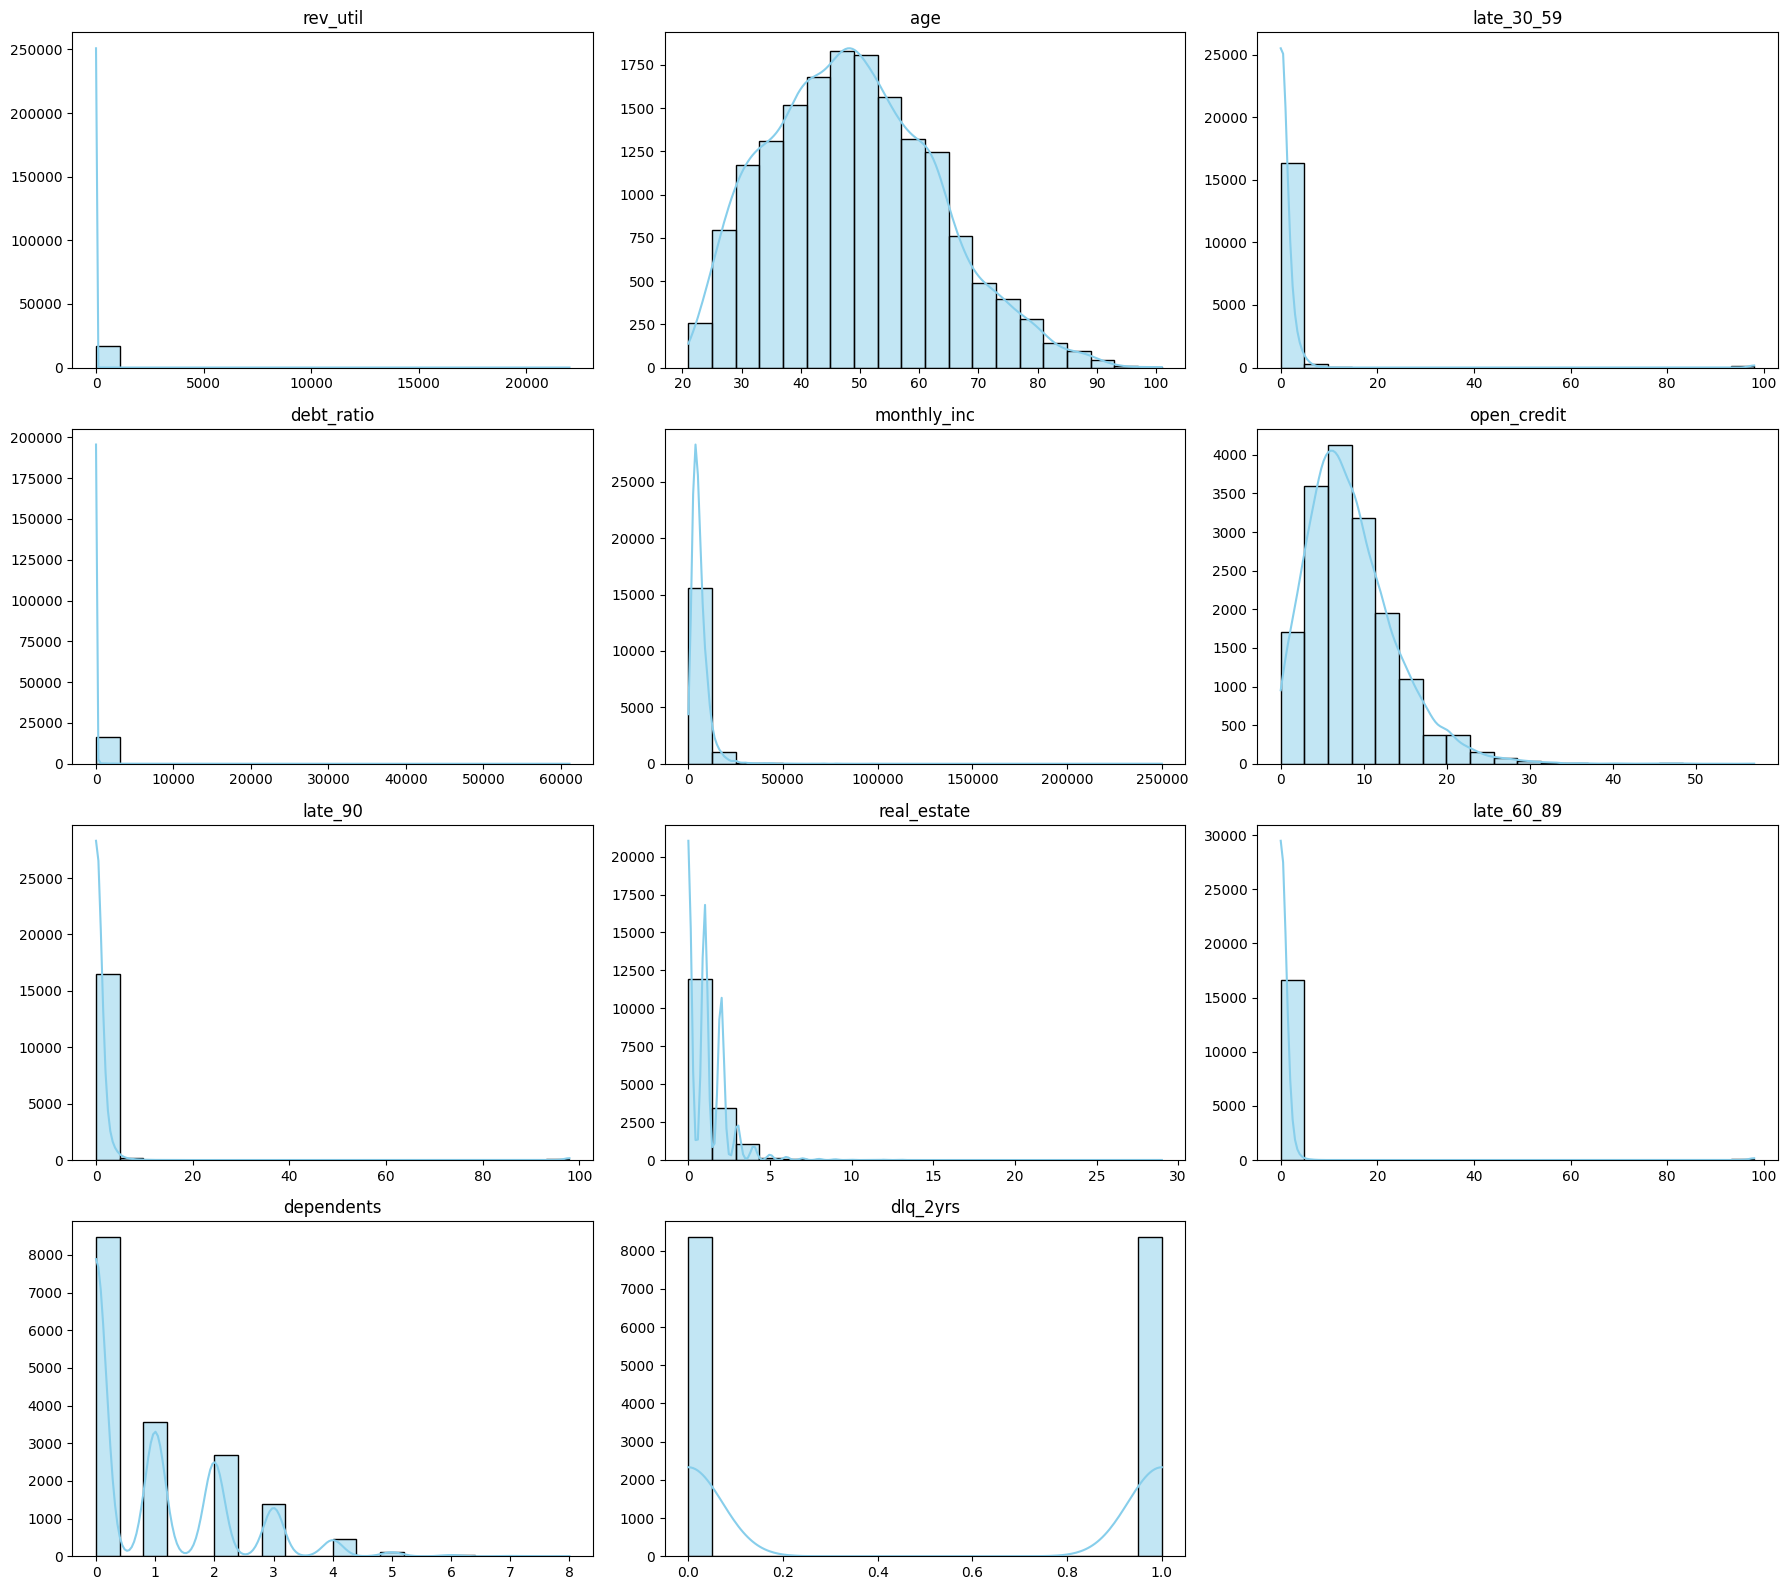

In [4]:
'''numeric_cols = df.select_dtypes(include="number").columns
n_cols = 3
n_rows = int(np.ceil(len(numeric_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], bins=20, kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()'''

### Correlation Analysis

The correlation matrix heatmap reveals the following patterns and relationships:

**Strong Correlations (|p| > 0.7)**:
1. Late Payment Variables:
   - `late_30_59` ↔ `late_60_89`: ρ = 0.99
   - `late_60_89` ↔ `late_90`: ρ = 0.99
   - `late_30_59` ↔ `late_90`: ρ = 0.98
   - Suggests progression of payment difficulties
   - High multicollinearity risk for modeling

2. Credit Lines:
   - `real_estate` ↔ `open_credit`: ρ = 0.47
   - More real estate loans associated with more credit lines
   - May indicate higher creditworthiness

**Default Risk Correlations**:
1. Positive Correlations with `dlq_2yrs`:
   - `late_30_59`: ρ = 0.12 (strongest predictor)
   - `late_90`: ρ = 0.11 (second strongest predictor)

2. Negative Correlations with `dlq_2yrs`:
   - `age`: ρ = -0.21
   - `monthly_inc`: ρ = -0.082
   - Other features have little to no correlation with `dlq_2yrs`

**Feature Engineering Implications**:
1. Combine late payment variables to address multicollinearity
2. Create interaction terms between:
   - `rev_util` and `debt_ratio`
   - `monthly_inc` and `debt_ratio`
3. Consider age brackets rather than continuous age
4. Create composite credit profile features

These relationships suggest both direct risk factors (utilization, late payments) and protective factors (age, income, assets).


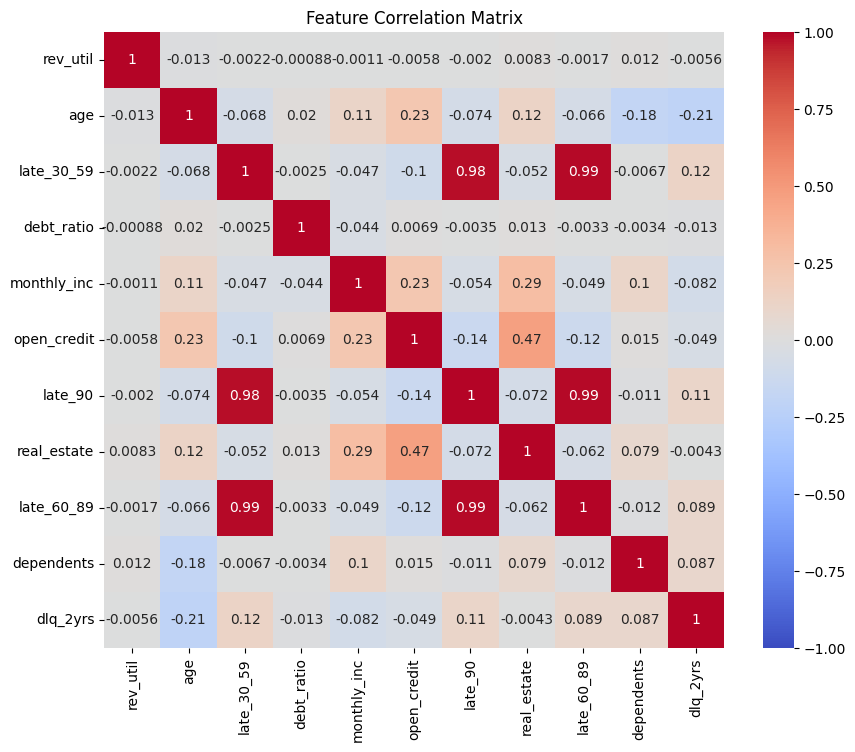

In [5]:
'''plt.figure(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, vmin=-1, vmax=1)
plt.title("Feature Correlation Matrix")
plt.show()'''

### Default vs Non-Default Comparison

The KDE plots reveal clear separations between defaulters and non-defaulters:

**Financial Health Indicators**:

1. Revolving Utilization (`rev_util`):
   - Defaulters: Heavy concentration above 80% utilization
   - Non-defaulters: Most below 50% utilization
   - Clear separation suggests strong predictive power
   - Potential threshold effect around 70-80%

2. Debt Ratio:
   - Defaulters: Higher concentration above 50% DTI
   - Non-defaulters: Peak around 30% DTI
   - Substantial overlap in middle ranges
   - Extreme values more common in default group

3. Monthly Income:
   - Defaulters: Mode around \$3,000-4,000
   - Non-defaulters: Mode around \$5,000-6,000
   - Significant overlap but clear shift
   - Income effect stronger at higher ranges

**Payment History**:

4. Late Payments (30-59, 60-89, 90+ days):
   - Defaulters: Much higher probability of past late payments
   - Non-defaulters: Concentrated at zero
   - Pattern strengthens with payment lateness
   - Strong evidence of payment history importance

**Demographic and Credit Profile**:

5. Age Distribution:
   - Defaulters: Peak around 35-40 years
   - Non-defaulters: Peak around 50-55 years
   - Clear age gradient in default risk
   - Suggests age-specific risk strategies

6. Credit Lines:
   - Defaulters: Fewer open credit lines
   - Non-defaulters: More diversified credit
   - Relationship possibly confounded with age/income

**Risk Assessment Implications**:
1. High utilization (>80%) is a strong red flag
2. Age and income provide protective effects
3. Any late payment history significantly increases risk
4. Multiple credit lines may indicate stability
5. Consider interaction effects in modeling

**Density**
   - Depend on:
      1. How spread out the data is (visualize a scatter plot)
      2. How concentrated the values are in certain ranges
      3. The total area under a curve is always 1

   `The more spread out the data is, the smaller density is. Density is NOT a probability, its just explaining how spread out the data is`
   
   (e.g) monthly_income:
      - Ranges from 0-250,000 (pre-processing), data is very spread out since the range is high, then the density must be very small [0.0000, 0.00014]

   (e.g) dependants:
      - Ranges from 0-8 (pre-processing), data is less spread out since range is low, then the overall density is high because the range is [0, 8]


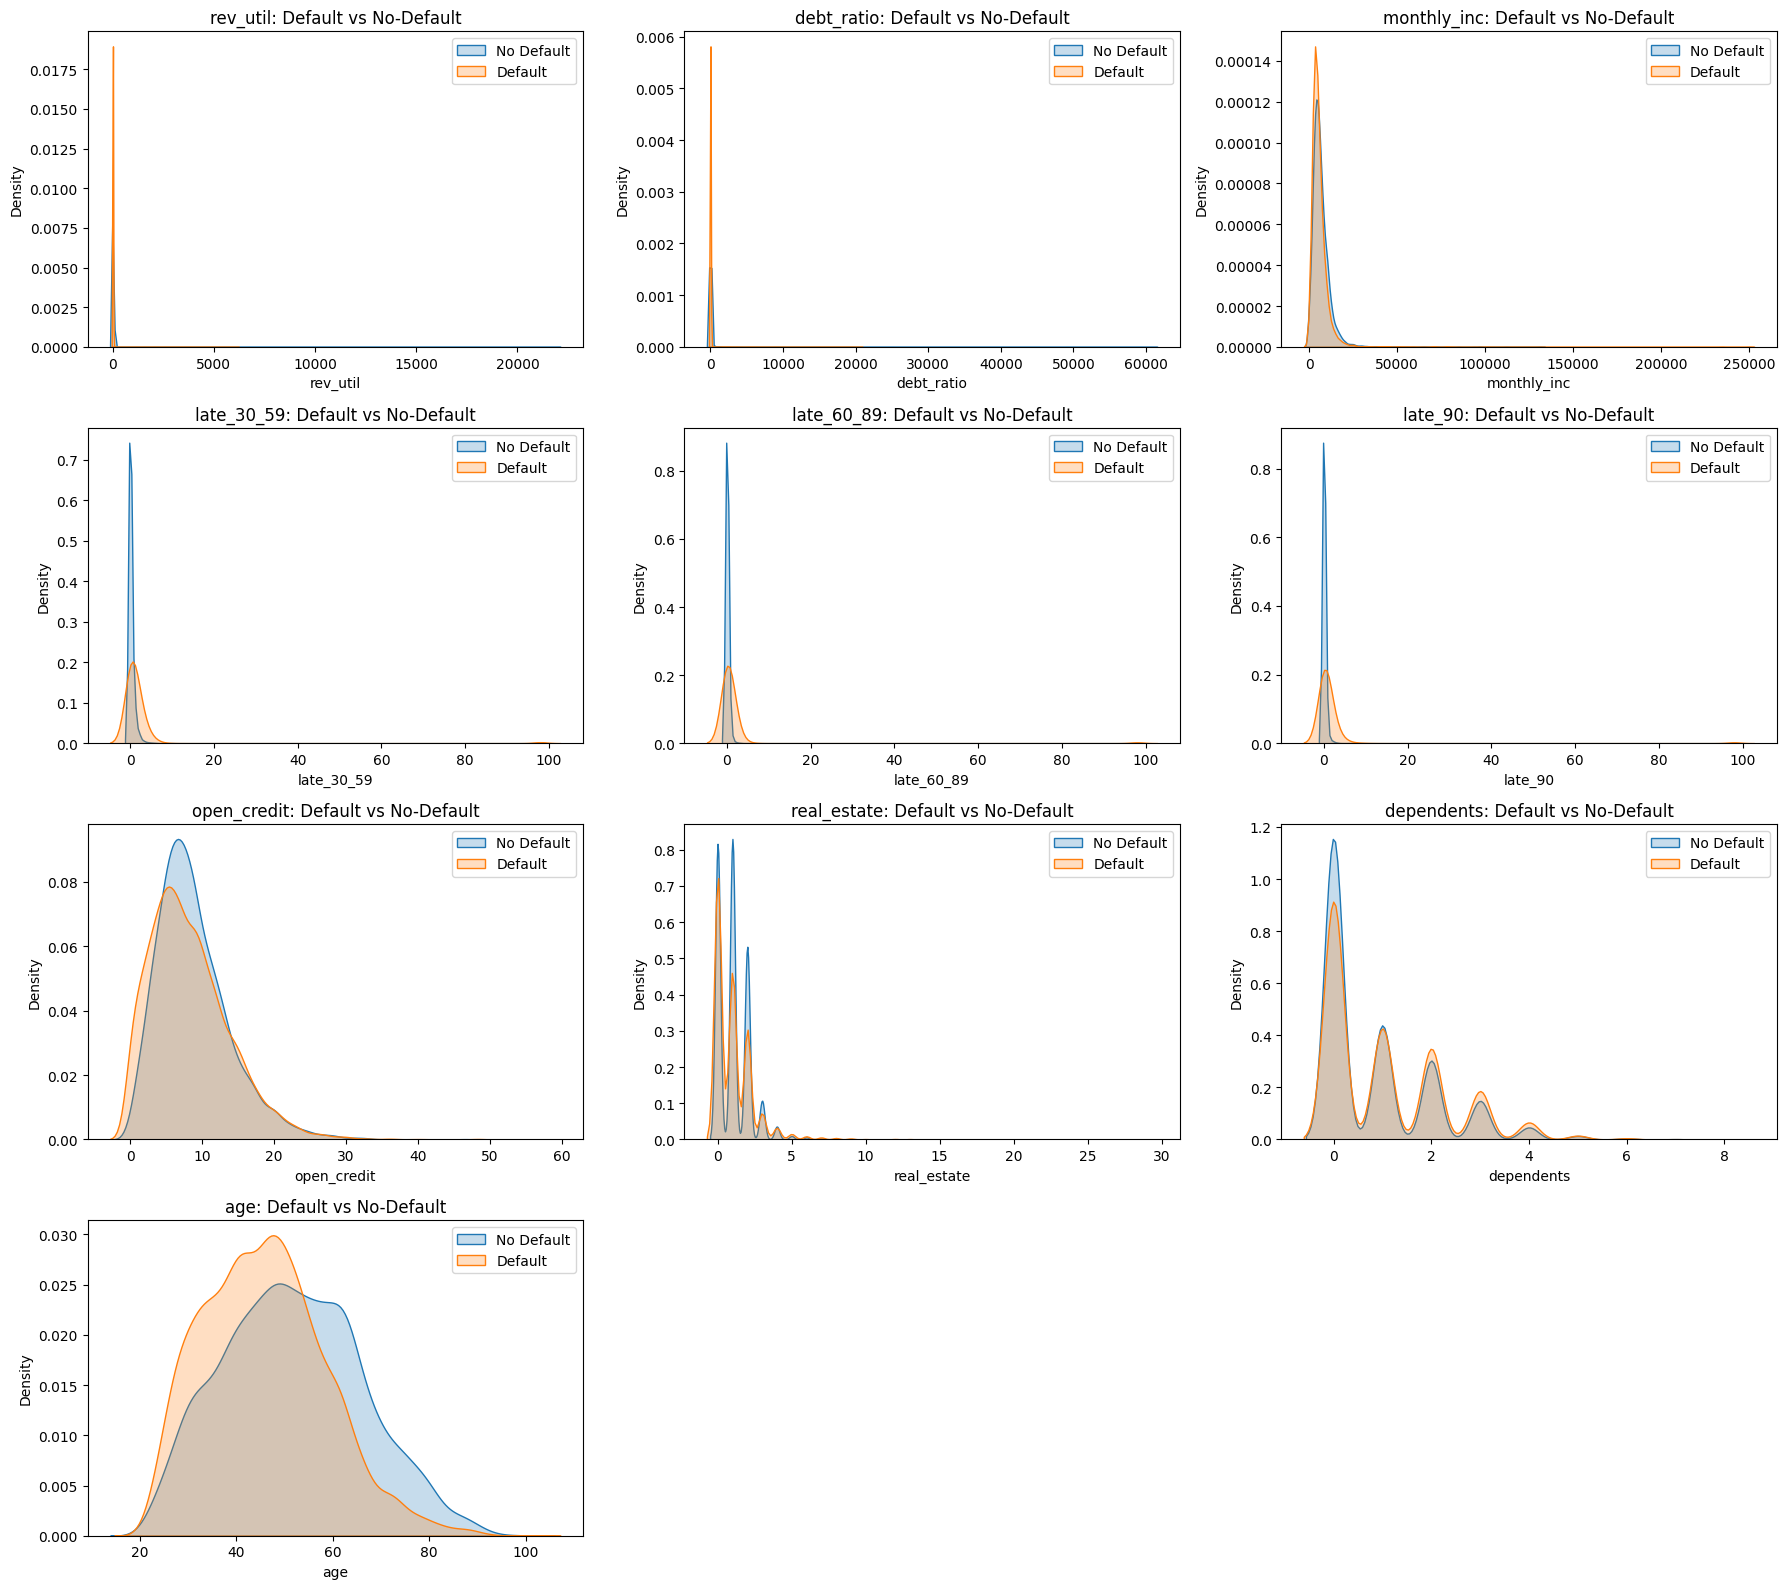

In [6]:

features = ["rev_util", "debt_ratio", "monthly_inc",
            "late_30_59", "late_60_89", "late_90",
            "open_credit", "real_estate", "dependents", "age"]

'''n_cols = 3
n_rows = int(np.ceil(len(features) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(features):
    sns.kdeplot(df[df.dlq_2yrs == 0][col], label="No Default", fill=True, ax=axes[i])
    sns.kdeplot(df[df.dlq_2yrs == 1][col], label="Default", fill=True, ax=axes[i])
    axes[i].set_title(f"{col}: Default vs No-Default")
    axes[i].legend()

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()'''

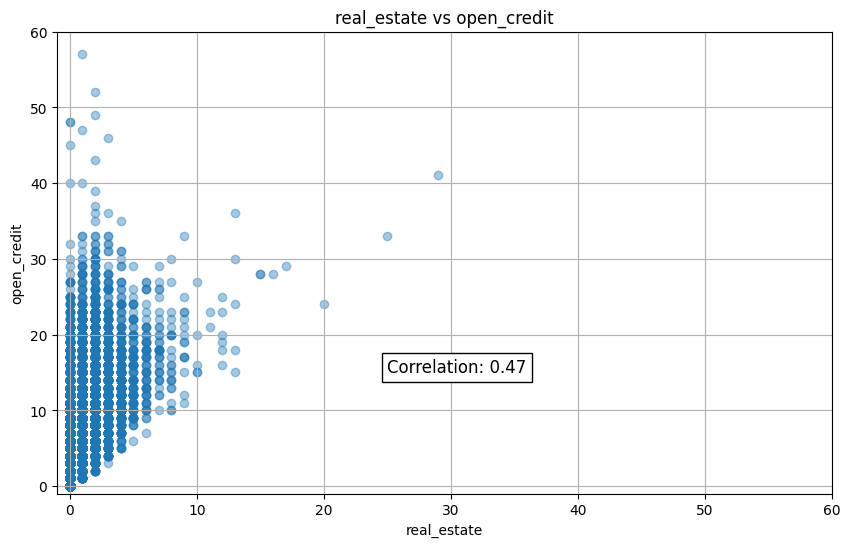

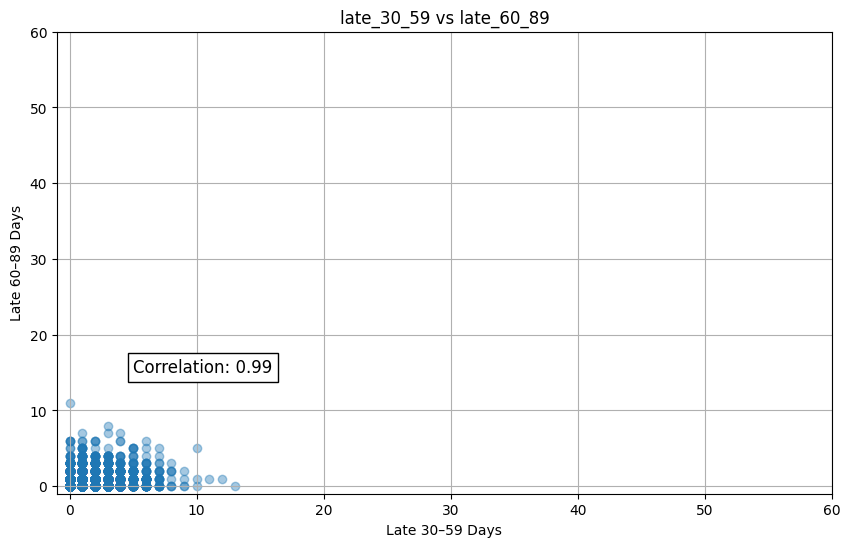

In [7]:
# real_estate vs open_credit
'''plt.figure(figsize=(10, 6))
plt.scatter(df["real_estate"], df["open_credit"], alpha=0.4)
plt.xlabel("real_estate")
plt.ylabel("open_credit")
plt.title("real_estate vs open_credit")

corr = df["real_estate"].corr(df["open_credit"])
plt.text(25, 15, f"Correlation: {corr:.2f}", fontsize=12, bbox=dict(facecolor='white', edgecolor='black'))
plt.xlim(-1, 60)
plt.ylim(-1, 60)
plt.grid(True)
plt.show()

# late_30_59 vs late_60_89
plt.figure(figsize=(10, 6))
plt.scatter(df["late_30_59"], df["late_60_89"], alpha=0.4)
plt.xlabel("Late 30–59 Days")
plt.ylabel("Late 60–89 Days")
plt.title("late_30_59 vs late_60_89")

corr = df["late_30_59"].corr(df["late_60_89"])
plt.text(5, 15, f"Correlation: {corr:.2f}", fontsize=12, bbox=dict(facecolor='white', edgecolor='black'))
plt.xlim(-1, 60)
plt.ylim(-1, 60)
plt.grid(True)
plt.show()'''


### Feature Engineering and Variable Transformation

Based on our comprehensive analysis, we implement several strategic transformations:

**1. Payment History Consolidation**:
- Created `total_late` = sum of all late payment variables
  - Addresses high multicollinearity (ρ > 0.9)
  - Captures overall payment reliability
  - Reduces dimensionality while preserving information

**2. Relative Payment Performance**:
- Introduced `late_ratio` = total_late / open_credit
  - Normalizes late payments by credit exposure
  - Handles scale differences between borrowers
  - More interpretable than raw counts

**3. Outlier Treatment**:
- Capped `debt_ratio` at 99th percentile
  - Original range: 0% to ~61,000%
  - Removes unrealistic values for better model

- Capped `monthly_inc` at 99th percentile
  - Original range: \$0 to $250,000
  - Reduces impact of extreme outliers for better model

**4. Age Stratification**:
Created meaningful age groups:
- 20-29: Early career (highest risk)
- 30-44: Career development
- 45-59: Peak earning years
- 60-79: Pre/early retirement
- 80+: Retirement (lowest risk)

Default rates show clear age gradient:
- 20-29: 62.6% default rate
- 30-44: 57.6%
- 45-59: 50.4%
- 60-79: 31.8%
- 80+: 25.4%

**5. Log Transformations**:
Applied log1p to heavily skewed variables:
- `rev_util`
- `debt_ratio`
- `monthly_inc`
- `total_late`
- `late_ratio`


0        0.000000
1        0.000000
2        0.000000
3        0.000000
4        0.000000
           ...   
16709    0.666667
16710    0.250000
16711    0.500000
16712    0.500000
16713    0.000000
Name: late_ratio, Length: 16712, dtype: float64


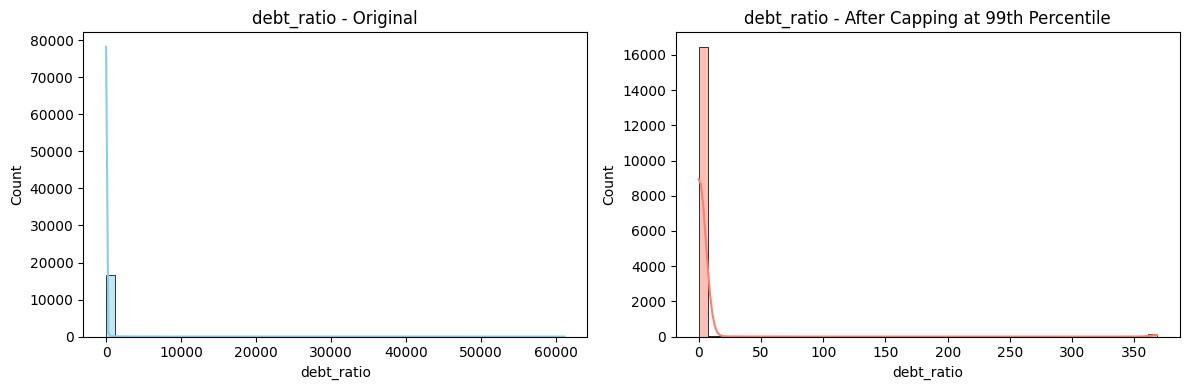

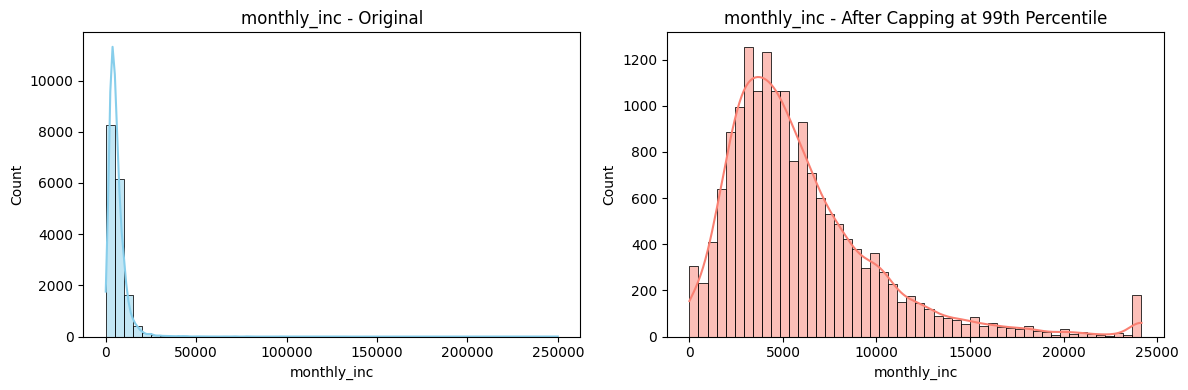

/tmp/ipython-input-8-3405206059.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="age_group", data=df, palette="muted", legend=False)


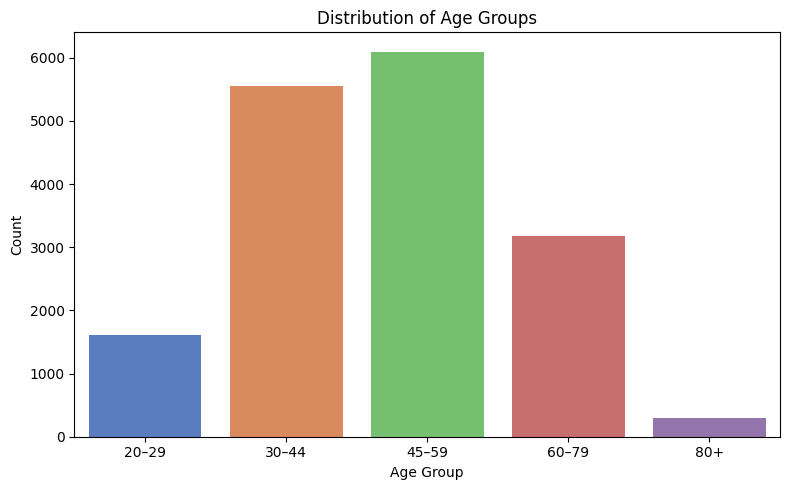

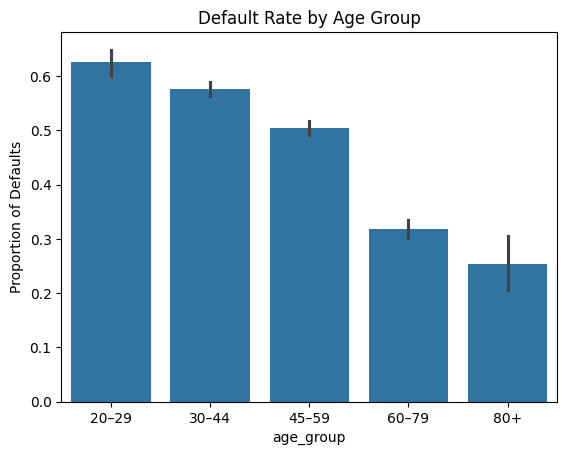

age_group
20–29    0.625389
30–44    0.576375
45–59    0.503526
60–79    0.318196
80+      0.254296
Name: dlq_2yrs, dtype: float64


/tmp/ipython-input-8-3405206059.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_rate = df.groupby("age_group")["dlq_2yrs"].mean()


In [8]:
df["total_late"] = df["late_30_59"] + df["late_60_89"] + df["late_90"]
df["late_ratio"] = df["total_late"] / df["open_credit"]
df["late_ratio"] = df["late_ratio"].replace([np.inf, -np.inf], 0)
df["late_ratio"].fillna(0)
print(df["late_ratio"])
for col in ["debt_ratio", "monthly_inc"]:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    sns.histplot(df[col], bins=50, kde=True, ax=axes[0], color='skyblue')
    axes[0].set_title(f"{col} - Original")

    upper = df[col].quantile(0.99)
    capped = df[col].clip(upper=upper)
    sns.histplot(capped, bins=50, kde=True, ax=axes[1], color='salmon')
    axes[1].set_title(f"{col} - After Capping at 99th Percentile")

    plt.tight_layout()
    plt.show()

bins = [20, 30, 45, 60, 80, 100]
labels = ["20–29", "30–44", "45–59", "60–79", "80+"]
df["age_group"] = pd.cut(df["age"], bins=bins, labels=labels)

plt.figure(figsize=(8, 5))
sns.countplot(x="age_group", data=df, palette="muted", legend=False)
plt.title("Distribution of Age Groups")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

sns.barplot(x="age_group", y="dlq_2yrs", data=df)
plt.title("Default Rate by Age Group")
plt.ylabel("Proportion of Defaults")
plt.show()

default_rate = df.groupby("age_group")["dlq_2yrs"].mean()
print(default_rate)

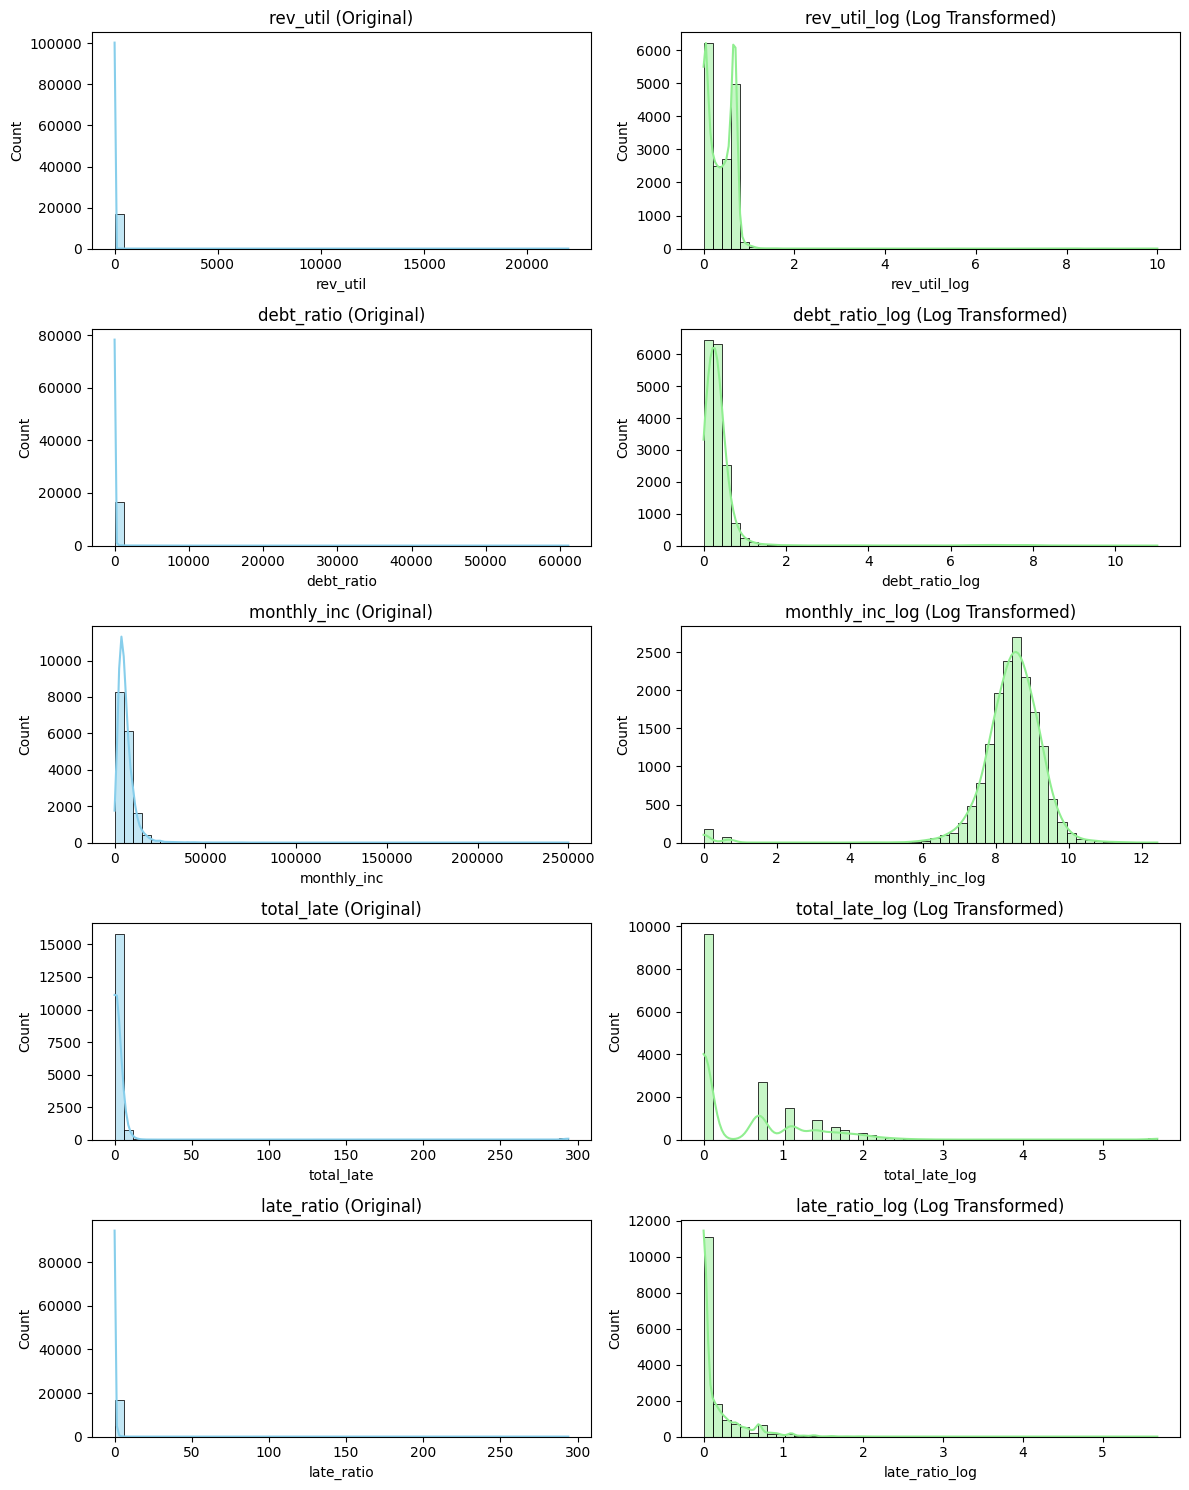

In [9]:
skewed = ["rev_util","debt_ratio","monthly_inc","total_late","late_ratio"]
for col in skewed:
    df[col + "_log"] = np.log1p(df[col])

n_cols = 2
n_rows = len(skewed)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 3))

for i, col in enumerate(skewed):
    sns.histplot(df[col], bins=50, kde=True, ax=axes[i, 0], color='skyblue')
    axes[i, 0].set_title(f"{col} (Original)")

    sns.histplot(df[col + "_log"], bins=50, kde=True, ax=axes[i, 1], color='lightgreen')
    axes[i, 1].set_title(f"{col}_log (Log Transformed)")

plt.tight_layout()
plt.show()



### Final Feature Analysis After Transformations

The visualization of original vs. transformed features reveals significant improvements:

**1. Distribution Improvements**:
- **Original Features**:
  - Extreme right skew in financial variables
  - Large gaps between median and mean
  - Difficult to visualize relationships
  - Outliers dominating scales

- **Log-Transformed Features**:
  - More symmetric distributions
  - Better spread of data points

**2. Default Risk Separation**:
- **rev_util_log**:
  - Clearer separation between risk groups
  - More uniform spread
  - Threshold effects more visible

- **debt_ratio_log**:
  - Reduced impact of extreme outliers
  - More interpretable relationship with default
  - Preserved important risk signals

- **monthly_inc_log**:
  - More normal distribution
  - Clearer income-risk relationship
  - Improved comparison across income levels (more standardized)

**3. Engineered Features Performance**:
- **total_late_log**:
  - Vombines payment history
  - Handles zero-inflation better
  - More stable for modeling

- **late_ratio**:
  - Clear risk stratification

**4. Final Correlation Structure**:
- Reduced multicollinearity
- Preserved key relationships
- Better feature independence
- Improved model stability potential

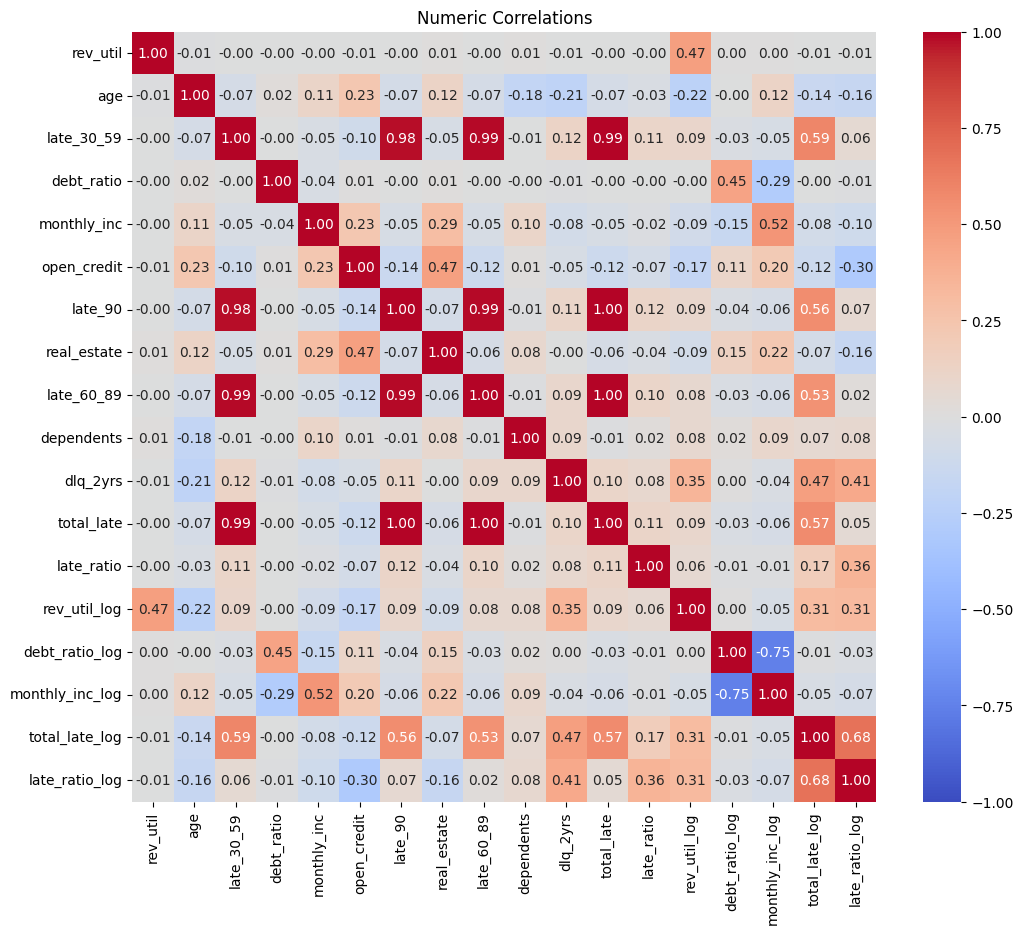

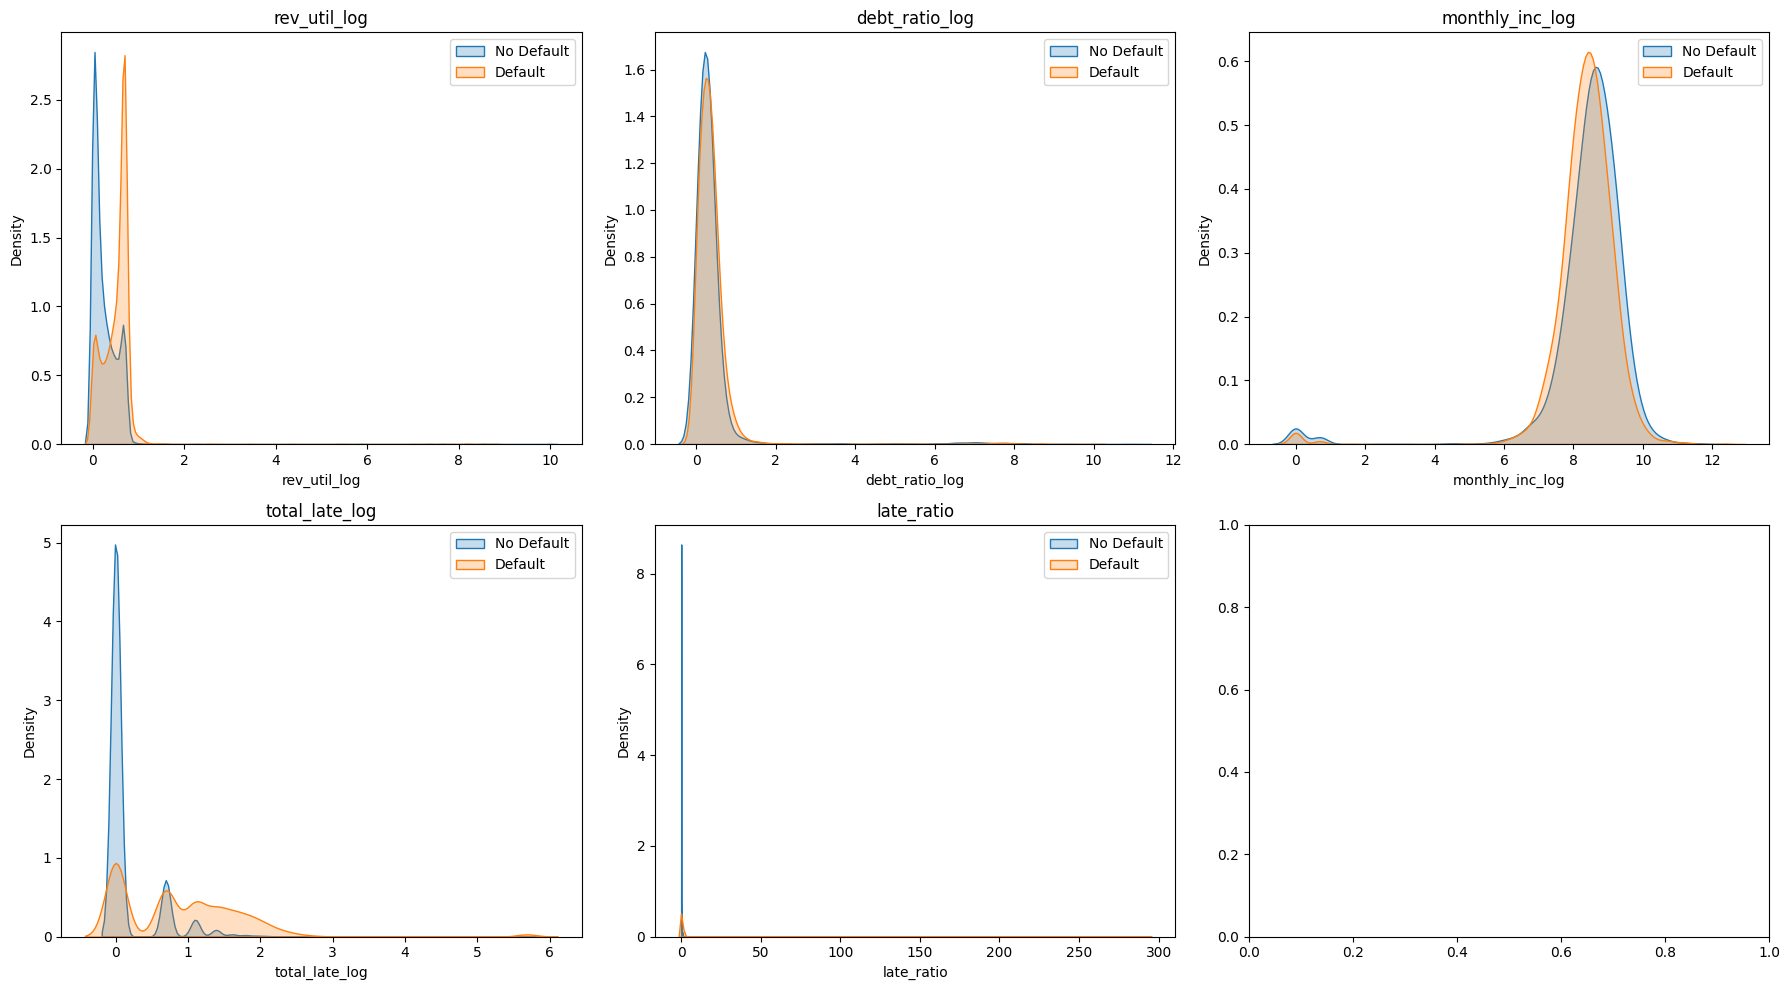

In [10]:
'''plt.figure(figsize=(12,10))
corr = df.select_dtypes(include="number").corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Numeric Correlations")
plt.show()

features = ["rev_util_log","debt_ratio_log","monthly_inc_log","total_late_log","late_ratio"]
fig, axes = plt.subplots(2, 3, figsize=(18,10)); axes = axes.flatten()
for i, col in enumerate(features):
    sns.kdeplot(df[df.dlq_2yrs==0][col], label="No Default", fill=True, ax=axes[i])
    sns.kdeplot(df[df.dlq_2yrs==1][col], label="Default", fill=True, ax=axes[i])
    axes[i].set_title(col)
    axes[i].legend()
plt.tight_layout()
plt.show()'''


# **Neural Networks**

Our next approach was to use Neural Networks. We start by setting up the differnt functions(ReLU, tanh, sigmoid), then create the Neural Network class and the associated functions to facilitate forward, backward propogations and parameter updates.

In [12]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
def sigmoid(z):
    """
    Sigmoid activation function: f(x) = 1 / (1 + e^(-x))
    """
    # Clip z to prevent overflow
    z = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z))

def relu(z):
    """
    ReLU activation function: f(x) = max(0, x)
    """
    return np.maximum(0, z)

def tanh(z):
    """
    Tanh activation function: f(x) = (e^x - e^(-x)) / (e^x + e^(-x))
    """
    return np.tanh(z)

# Derivative functions for backpropagation
def sigmoid_derivative(z):
    """Derivative of sigmoid function"""
    s = sigmoid(z)
    return s * (1 - s)

def relu_derivative(z):
    """Derivative of ReLU function"""
    return (z > 0).astype(float)

def tanh_derivative(z):
    """Derivative of tanh function"""
    return 1 - np.tanh(z) ** 2

Creating the class NeuralNetwork

In [13]:
class NeuralNetwork:
    def __init__(self, layer_sizes, activations):
        """
        Initialize a neural network with specified layer sizes and activation functions.

        Parameters:
        layer_sizes (list): List of integers specifying the number of neurons in each layer.
            The first element is the input size, the last is the output size.
        activations (list): List of strings specifying the activation function for each layer.
            Should be one less than the length of layer_sizes.

        Notation:
        - a^[i]_j: jth neuron activation in ith layer
        - z^[i]_j: jth neuron pre-activation in ith layer
        """
        if len(layer_sizes) < 2:
            raise ValueError("At least two layers (input and output) are required.")
        if len(activations) != len(layer_sizes) - 1:
            raise ValueError("Number of activation functions must match the number of layers - 1.")

        self.layer_sizes = layer_sizes
        self.num_layers = len(layer_sizes)
        self.activations = activations
        self.loss_history = []
        self.accuracy_history = []

        # Initialize weights and biases
        self.parameters = {}
        self.initialize_parameters()

        # Activation function mapping
        self.activation_functions = {
            'sigmoid': sigmoid,
            'relu': relu,
            'tanh': tanh
        }
        # Derivative function mapping
        self.activation_derivatives = {
            'sigmoid': sigmoid_derivative,
            'relu': relu_derivative,
            'tanh': tanh_derivative
        }

    def initialize_parameters(self):
        """
        Initialize the weights and biases for each layer using random initialization.
        """
        for l in range(1, self.num_layers):
            # Initialize weights with small random values
            self.parameters[f'W{l}'] = np.random.randn(self.layer_sizes[l], self.layer_sizes[l-1]) * 0.1
            # Initialize biases to zero
            self.parameters[f'b{l}'] = np.zeros((self.layer_sizes[l], 1))

    def forward_propagation(self, X):
        """
        Perform forward propagation through the network.

        Parameters:
        X (numpy.ndarray): Input data, shape (n_samples, n_features)

        Returns:
        dict: Dictionary containing activations and pre-activations for each layer
              Using notation: a^[i] for layer i activations, z^[i] for layer i pre-activations
        """
        cache = {}
        a = X.T  # Transpose to get shape (n_features, n_samples) - this is a^[0]
        cache['a^[0]'] = a  # Input layer activations

        for l in range(1, self.num_layers):
            W = self.parameters[f'W{l}']
            b = self.parameters[f'b{l}']

            # Linear transformation: z^[l] = W^[l] * a^[l-1] + b^[l]
            z = np.dot(W, a) + b
            cache[f'z^[{l}]'] = z  # Pre-activations for layer l

            # Apply activation function: a^[l] = g(z^[l])
            activation_func = self.activation_functions[self.activations[l-1]]
            a = activation_func(z)
            cache[f'a^[{l}]'] = a  # Activations for layer l
        return cache

    def backward_propagation(self, cache, Y):
        """
        Perform backward propagation to compute gradients.

        Parameters:
        cache (dict): Dictionary containing activations and pre-activations from forward pass
        Y (numpy.ndarray): True labels, shape (n_samples, n_output)

        Returns:
        dict: Dictionary containing gradients for weights and biases
        """
        gradients = {}

        # Get final layer activations
        AL = cache[f'a^[{self.num_layers-1}]']

        # Ensure Y has the same shape as AL
        if Y.ndim == 2 and Y.shape[0] != AL.shape[0]:
            Y = Y.T
        elif Y.ndim == 1:
            Y = Y.reshape(1, -1)

        m = AL.shape[1]  # Number of samples

        # Initialize backward propagation - this is dA for the output layer
        dA = AL - Y

        # Backward propagation from output layer to input layer
        for l in reversed(range(1, self.num_layers)):
            # Current layer's cached values
            current_cache_z = cache[f'z^[{l}]']
            current_cache_a_prev = cache[f'a^[{l-1}]']

            # For output layer, dA is already computed above
            # For hidden layers, we need to apply activation derivative
            if l == self.num_layers - 1:
                # Output layer: dA is already AL - Y
                dZ = dA
            else:
                # Hidden layers: dZ = dA * g'(z)
                activation_derivative = self.activation_derivatives[self.activations[l-1]]
                dZ = dA * activation_derivative(current_cache_z)

            # Compute gradients for current layer
            gradients[f'dW{l}'] = (1/m) * np.dot(dZ, current_cache_a_prev.T)
            gradients[f'db{l}'] = (1/m) * np.sum(dZ, axis=1, keepdims=True)

            # Compute dA for previous layer (except for input layer)
            if l > 1:
                dA = np.dot(self.parameters[f'W{l}'].T, dZ)

        return gradients

    def update_parameters(self, gradients, learning_rate):
        """
        Update parameters using gradient descent.

        Parameters:
        gradients (dict): Dictionary containing gradients
        learning_rate (float): Learning rate for gradient descent
        """
        for l in range(1, self.num_layers):
            self.parameters[f'W{l}'] -= learning_rate * gradients[f'dW{l}']
            self.parameters[f'b{l}'] -= learning_rate * gradients[f'db{l}']

    def compute_cost(self, AL, Y):
        """
        Compute the binary cross-entropy cost.

        Parameters:
        AL (numpy.ndarray): Output predictions from forward propagation
        Y (numpy.ndarray): True labels

        Returns:
        float: Cost value
        """
        m = Y.shape[1]
        Y = Y.T if Y.shape[0] != AL.shape[0] else Y

        # Clip predictions to prevent log(0)
        AL = np.clip(AL, 1e-15, 1 - 1e-15)

        # Binary cross-entropy cost
        cost = -(1/m) * np.sum(Y * np.log(AL) + (1 - Y) * np.log(1 - AL))
        return cost

    def feedforward(self, X):
        """
        Alias for forward_propagation that returns final output (following your naming convention)
        """
        cache = self.forward_propagation(X)
        return cache[f'a^[{self.num_layers-1}]'].T  # Return final output, transposed to match input format

    def backward(self, X, y, learning_rate):
        """
        Combined backward propagation and parameter update
        """
        # Need to do forward pass to get cache for backprop
        cache = self.forward_propagation(X)

        # Backward propagation - pass y as is, let backward_propagation handle the shape
        gradients = self.backward_propagation(cache, y)

        # Update parameters
        self.update_parameters(gradients, learning_rate)

    def train(self, X, y, epochs, learning_rate):
        """
        Train the neural network following your exact pattern.

        Parameters:
        X (numpy.ndarray): Training features
        y (numpy.ndarray): Training labels
        epochs (int): Number of training epochs
        learning_rate (float): Learning rate for gradient descent
        """
        for epoch in range(epochs):
            output = self.feedforward(X)
            self.backward(X, y, learning_rate)
            if epoch % 4000 == 0:
                loss = np.mean(np.square(y - output))
                print(f"Epoch {epoch}, Loss:{loss}")
                self.loss_history.append(loss)

    def predict(self, X, threshold=0.5):
        """
        Predict binary classes.

        Parameters:
        X (numpy.ndarray): Input features
        threshold (float): Classification threshold

        Returns:
        numpy.ndarray: Binary class predictions
        """
        probabilities = self.feedforward(X)
        return (probabilities > threshold).astype(int)

    def evaluate(self, X, Y):
        """
        Evaluate model performance.

        Parameters:
        X (numpy.ndarray): Test features
        Y (numpy.ndarray): Test labels

        Returns:
        float: Accuracy score
        """
        predictions = self.predict(X)
        accuracy = accuracy_score(Y, predictions)

        print(f"Accuracy: {accuracy:.4f}")
        print("\nConfusion Matrix:")
        print(confusion_matrix(Y, predictions))
        return accuracy

    def plot_training_metrices(self):

        print(f"Loss history length: {len(self.loss_history)}")
        print(f"Loss values: {self.loss_history}")

        #safety check for enough points are available for useful plot
        #self.loss_hostory holds loss values from train
        if len(self.loss_history)<2:
            return #only when less then 2 points available.

        plt.figure(figsize=(10, 4))
        plt.plot(self.loss_history, 'b--' , linewidth=2)
        plt.title('Training Loss Over Time')
        plt.xlabel('Checkpoint (every 4000 epochs)')
        plt.ylabel('Loss')
        plt.grid(True, alpha=0.3)

        plt.draw()
        plt.pause(0.1)
        plt.show(block=False)

    def plot_training_history(self):
        """Plot training loss and accuracy"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

        # Loss plot
        ax1.plot(self.loss_history)
        ax1.set_title('Training Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.grid(True)

        # Accuracy plot
        if self.accuracy_history:
            ax2.plot(self.accuracy_history)
            ax2.set_title('Validation Accuracy')
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Accuracy')
            ax2.grid(True)

        plt.tight_layout()
        plt.show()

    def get_architecture_info(self):
        """
        Get information about the network architecture.
        """
        info = {
            'layer_sizes': self.layer_sizes,
            'activations': self.activations,
            'total_parameters': sum([w.size + b.size for w, b in
                                   [(self.parameters[f'W{l}'], self.parameters[f'b{l}'])
                                    for l in range(1, self.num_layers)]])
        }
        return info

    def train_with_cross_validation(self, X, y, epochs, learning_rate, cv_folds=5, verbose=True):
        """
        Train the neural network using stratified k-fold cross-validation.

        Parameters:
        X (numpy.ndarray): Training features
        y (numpy.ndarray): Training labels
        epochs (int): Number of training epochs per fold
        learning_rate (float): Learning rate for gradient descent
        cv_folds (int): Number of cross-validation folds
        verbose (bool): Whether to print progress information

        Returns:
        dict: Dictionary containing cross-validation results
        """
        # Use stratified k-fold cross-validation
        kfold = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
        # For stratified, we need 1D labels
        y_for_split = y.ravel() if y.ndim > 1 else y

        # Store results for each fold
        fold_results = {
            'train_accuracies': [],
            'val_accuracies': [],
            'train_losses': [],
            'val_losses': [],
            'fold_histories': []
        }

        if verbose:
            print(f"Starting {cv_folds}-fold stratified cross-validation...")

        for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y_for_split)):
            if verbose:
                print(f"\nFold {fold + 1}/{cv_folds}")

            # Split data
            X_train_fold, X_val_fold = X[train_idx], X[val_idx]
            y_train_fold, y_val_fold = y[train_idx], y[val_idx]

            # Reinitialize parameters for each fold
            self.initialize_parameters()

            # Track history for this fold
            fold_train_losses = []
            fold_val_losses = []
            fold_train_accuracies = []
            fold_val_accuracies = []

            # Training loop for this fold
            for epoch in range(epochs):
                # Forward pass
                train_output = self.feedforward(X_train_fold)

                # Backward pass
                self.backward(X_train_fold, y_train_fold, learning_rate)

                # Calculate metrics every 1000 epochs or at the end
                if epoch % 1000 == 0 or epoch == epochs - 1:
                    # Training metrics
                    train_loss = np.mean(np.square(y_train_fold - train_output))
                    train_pred = self.predict(X_train_fold)
                    train_acc = accuracy_score(y_train_fold, train_pred)

                    # Validation metrics
                    val_output = self.feedforward(X_val_fold)
                    val_loss = np.mean(np.square(y_val_fold - val_output))
                    val_pred = self.predict(X_val_fold)
                    val_acc = accuracy_score(y_val_fold, val_pred)

                    fold_train_losses.append(train_loss)
                    fold_val_losses.append(val_loss)
                    fold_train_accuracies.append(train_acc)
                    fold_val_accuracies.append(val_acc)

                    if verbose and epoch % 4000 == 0:
                        print(f"  Epoch {epoch} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
                        print(f"  Epoch {epoch} - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

            # Store final results for this fold
            fold_results['train_accuracies'].append(fold_train_accuracies[-1])
            fold_results['val_accuracies'].append(fold_val_accuracies[-1])
            fold_results['train_losses'].append(fold_train_losses[-1])
            fold_results['val_losses'].append(fold_val_losses[-1])
            fold_results['fold_histories'].append({
                'train_losses': fold_train_losses,
                'val_losses': fold_val_losses,
                'train_accuracies': fold_train_accuracies,
                'val_accuracies': fold_val_accuracies
            })

            if verbose:
                print(f"  Final - Train Acc: {fold_train_accuracies[-1]:.4f}, Val Acc: {fold_val_accuracies[-1]:.4f}")

        # Calculate summary statistics
        results = {
            'mean_train_accuracy': np.mean(fold_results['train_accuracies']),
            'std_train_accuracy': np.std(fold_results['train_accuracies']),
            'mean_val_accuracy': np.mean(fold_results['val_accuracies']),
            'std_val_accuracy': np.std(fold_results['val_accuracies']),
            'mean_train_loss': np.mean(fold_results['train_losses']),
            'std_train_loss': np.std(fold_results['train_losses']),
            'mean_val_loss': np.mean(fold_results['val_losses']),
            'std_val_loss': np.std(fold_results['val_losses']),
            'fold_details': fold_results
        }

        if verbose:
            print(f"\n{'='*50}")
            print("CROSS-VALIDATION RESULTS:")
            print(f"{'='*50}")
            print(f"Mean Validation Accuracy: {results['mean_val_accuracy']:.4f} ± {results['std_val_accuracy']:.4f}")
            print(f"Mean Training Accuracy: {results['mean_train_accuracy']:.4f} ± {results['std_train_accuracy']:.4f}")
            print(f"Mean Validation Loss: {results['mean_val_loss']:.4f} ± {results['std_val_loss']:.4f}")
            print(f"Mean Training Loss: {results['mean_train_loss']:.4f} ± {results['std_train_loss']:.4f}")

        return results

    def plot_cv_results(self, cv_results):
        """
        Plot cross-validation results showing performance across folds.

        Parameters:
        cv_results (dict): Results from train_with_cross_validation
        """
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Plot 1: Accuracy across folds
        folds = range(1, len(cv_results['fold_details']['train_accuracies']) + 1)

        axes[0, 0].bar([f - 0.2 for f in folds], cv_results['fold_details']['train_accuracies'],
                      width=0.4, label='Training', alpha=0.7)
        axes[0, 0].bar([f + 0.2 for f in folds], cv_results['fold_details']['val_accuracies'],
                      width=0.4, label='Validation', alpha=0.7)
        axes[0, 0].set_xlabel('Fold')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].set_title('Accuracy Across Folds')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # Plot 2: Loss across folds
        axes[0, 1].bar([f - 0.2 for f in folds], cv_results['fold_details']['train_losses'],
                      width=0.4, label='Training', alpha=0.7)
        axes[0, 1].bar([f + 0.2 for f in folds], cv_results['fold_details']['val_losses'],
                      width=0.4, label='Validation', alpha=0.7)
        axes[0, 1].set_xlabel('Fold')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].set_title('Loss Across Folds')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

        # Plot 3: Training curves for all folds (validation accuracy)
        for i, fold_history in enumerate(cv_results['fold_details']['fold_histories']):
            epochs = range(0, len(fold_history['val_accuracies']) * 1000, 1000)
            axes[1, 0].plot(epochs, fold_history['val_accuracies'], alpha=0.7, label=f'Fold {i+1}')
        axes[1, 0].set_xlabel('Epochs')
        axes[1, 0].set_ylabel('Validation Accuracy')
        axes[1, 0].set_title('Validation Accuracy During Training')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

        # Plot 4: Training curves for all folds (validation loss)
        for i, fold_history in enumerate(cv_results['fold_details']['fold_histories']):
            epochs = range(0, len(fold_history['val_losses']) * 1000, 1000)
            axes[1, 1].plot(epochs, fold_history['val_losses'], alpha=0.7, label=f'Fold {i+1}')
        axes[1, 1].set_xlabel('Epochs')
        axes[1, 1].set_ylabel('Validation Loss')
        axes[1, 1].set_title('Validation Loss During Training')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def train_with_holdout_validation(self, X, y, epochs, learning_rate, validation_split=0.2,
                                    early_stopping=True, patience=10, verbose=True):
        """
        Train with holdout validation and optional early stopping.

        Parameters:
        X (numpy.ndarray): Training features
        y (numpy.ndarray): Training labels
        epochs (int): Maximum number of training epochs
        learning_rate (float): Learning rate for gradient descent
        validation_split (float): Fraction of data to use for validation
        early_stopping (bool): Whether to use early stopping
        patience (int): Number of epochs to wait for improvement before stopping
        verbose (bool): Whether to print progress

        Returns:
        dict: Training history and results
        """
        # Split data
        n_samples = X.shape[0]
        n_val = int(n_samples * validation_split)

        # Shuffle indices
        indices = np.random.permutation(n_samples)
        val_idx = indices[:n_val]
        train_idx = indices[n_val:]

        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Initialize tracking variables
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        best_val_loss = float('inf')
        patience_counter = 0
        best_parameters = None

        if verbose:
            print(f"Training with {len(train_idx)} samples, validating with {len(val_idx)} samples")

        for epoch in range(epochs):
            # Training step
            train_output = self.feedforward(X_train)
            self.backward(X_train, y_train, learning_rate)

            # Calculate metrics
            if epoch % 100 == 0 or epoch == epochs - 1:
                train_loss = np.mean(np.square(y_train - train_output))
                train_pred = self.predict(X_train)
                train_acc = accuracy_score(y_train, train_pred)

                val_output = self.feedforward(X_val)
                val_loss = np.mean(np.square(y_val - val_output))
                val_pred = self.predict(X_val)
                val_acc = accuracy_score(y_val, val_pred)

                train_losses.append(train_loss)
                val_losses.append(val_loss)
                train_accuracies.append(train_acc)
                val_accuracies.append(val_acc)

                if verbose and epoch % 1000 == 0:
                    print(f"Epoch {epoch} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
                    print(f"Epoch {epoch} - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

                # Early stopping check
                if early_stopping:
                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        patience_counter = 0
                        # Save best parameters
                        best_parameters = {key: value.copy() for key, value in self.parameters.items()}
                    else:
                        patience_counter += 1

                    if patience_counter >= patience:
                        if verbose:
                            print(f"Early stopping at epoch {epoch}")
                        # Restore best parameters
                        if best_parameters:
                            self.parameters = best_parameters
                        break

        results = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accuracies': train_accuracies,
            'val_accuracies': val_accuracies,
            'final_train_acc': train_accuracies[-1],
            'final_val_acc': val_accuracies[-1],
            'best_val_loss': best_val_loss,
            'stopped_early': early_stopping and patience_counter >= patience,
            'epochs_trained': epoch + 1
        }

        return results
    def compare_configurations(self):
        """Compare different network configurations using cross-validation"""

        configurations = [
            {'layer_sizes': [5, 3, 1], 'activations': ['relu', 'sigmoid']},
            {'layer_sizes': [5, 8, 1], 'activations': ['relu', 'sigmoid']},
        ]

        results = {}

        for i, config in enumerate(configurations):
            print(f"\nTesting configuration {i+1}: {config}")

            nn = NeuralNetwork(
                layer_sizes=config['layer_sizes'],
                activations=config['activations']
            )

            cv_results = nn.train_with_cross_validation(
                X=X_train,
                y=y_train,
                epochs=8000,
                learning_rate=0.01,
                cv_folds=5,
                verbose=False  # Set to False for cleaner output
            )

            results[f"Config_{i+1}"] = cv_results
            print(f"Mean CV Accuracy: {cv_results['mean_val_accuracy']:.4f} ± {cv_results['std_val_accuracy']:.4f}")

        # Plot comparison
        configs = list(results.keys())
        means = [results[config]['mean_val_accuracy'] for config in configs]
        stds = [results[config]['std_val_accuracy'] for config in configs]
        plt.figure(figsize=(10, 6))
        plt.errorbar(configs, means, yerr=stds, fmt='o-', capsize=5, capthick=2)
        plt.xlabel('Configuration')
        plt.ylabel('Cross-Validation Accuracy')
        plt.title('Model Configuration Comparison')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        return results


    def plot_learning_curves(self, X, y, train_sizes=None, cv_folds=5, epochs=5000, learning_rate=0.01):
        """
        Generate learning curves showing how model performance changes with training set size.
        This helps diagnose bias vs variance issues.

        Parameters:
        X (numpy.ndarray): Full dataset features
        y (numpy.ndarray): Full dataset labels
        train_sizes (array): Different training set sizes to test
        cv_folds (int): Number of CV folds for each training size
        epochs (int): Number of epochs to train for each size
        learning_rate (float): Learning rate for training

        Returns:
        dict: Dictionary containing learning curve results
        """
        from sklearn.model_selection import learning_curve
        import matplotlib.pyplot as plt

        if train_sizes is None:
            train_sizes = np.linspace(0.1, 1.0, 10)

        # Convert relative sizes to absolute sizes
        n_samples = X.shape[0]
        absolute_sizes = [int(size * n_samples) if size <= 1.0 else int(size) for size in train_sizes]

        train_scores_mean = []
        train_scores_std = []
        val_scores_mean = []
        val_scores_std = []

        print("Generating learning curves...")

        for i, train_size in enumerate(absolute_sizes):
            print(f"Training size: {train_size}/{n_samples} ({train_size/n_samples:.2%})")

            # Use stratified k-fold
            kfold = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
            y_for_split = y.ravel() if y.ndim > 1 else y

            fold_train_scores = []
            fold_val_scores = []

            for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y_for_split)):
                # Limit training set to current size
                if len(train_idx) > train_size:
                    train_idx = train_idx[:train_size]

                X_train_fold, X_val_fold = X[train_idx], X[val_idx]
                y_train_fold, y_val_fold = y[train_idx], y[val_idx]

                # Reinitialize parameters for each fold
                self.initialize_parameters()

                # Train the model
                for epoch in range(epochs):
                    self.backward(X_train_fold, y_train_fold, learning_rate)

                # Evaluate on both training and validation sets
                train_pred = self.predict(X_train_fold)
                val_pred = self.predict(X_val_fold)

                train_acc = accuracy_score(y_train_fold, train_pred)
                val_acc = accuracy_score(y_val_fold, val_pred)

                fold_train_scores.append(train_acc)
                fold_val_scores.append(val_acc)

            # Store mean and std for this training size
            train_scores_mean.append(np.mean(fold_train_scores))
            train_scores_std.append(np.std(fold_train_scores))
            val_scores_mean.append(np.mean(fold_val_scores))
            val_scores_std.append(np.std(fold_val_scores))

            print(f"  Train Acc: {train_scores_mean[-1]:.4f} ± {train_scores_std[-1]:.4f}")
            print(f"  Val Acc: {val_scores_mean[-1]:.4f} ± {val_scores_std[-1]:.4f}")

        # Plot learning curves
        plt.figure(figsize=(10, 6))

        plt.fill_between(absolute_sizes,
                        np.array(train_scores_mean) - np.array(train_scores_std),
                        np.array(train_scores_mean) + np.array(train_scores_std),
                        alpha=0.1, color="r")
        plt.fill_between(absolute_sizes,
                        np.array(val_scores_mean) - np.array(val_scores_std),
                        np.array(val_scores_mean) + np.array(val_scores_std),
                        alpha=0.1, color="g")

        plt.plot(absolute_sizes, train_scores_mean, 'o-', color="r", label="Training score")
        plt.plot(absolute_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")

        plt.xlabel('Training Set Size')
        plt.ylabel('Accuracy Score')
        plt.title('Learning Curves - Credit Risk Assessment')
        plt.legend(loc="best")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        # Analyze the curves
        final_gap = train_scores_mean[-1] - val_scores_mean[-1]
        print(f"\n{'='*50}")
        print("LEARNING CURVE ANALYSIS:")
        print(f"{'='*50}")
        print(f"Final training accuracy: {train_scores_mean[-1]:.4f}")
        print(f"Final validation accuracy: {val_scores_mean[-1]:.4f}")
        print(f"Training-validation gap: {final_gap:.4f}")

        if final_gap > 0.1:
            print("⚠️  HIGH VARIANCE: Large gap suggests overfitting")
        elif val_scores_mean[-1] < 0.8:
            print("⚠️  HIGH BIAS: Low validation accuracy suggests underfitting")
        else:
            print("✅ GOOD BALANCE: Model appears well-tuned")

        return {
            'train_sizes': absolute_sizes,
            'train_scores_mean': train_scores_mean,
            'train_scores_std': train_scores_std,
            'val_scores_mean': val_scores_mean,
            'val_scores_std': val_scores_std
        }

    def validation_curves(self, X, y, param_name, param_range, cv_folds=5, epochs=3000, learning_rate=0.01):
        """
        Generate validation curves to find optimal hyperparameter values.

        Parameters:
        X, y: Training data
        param_name (str): Name of parameter to vary ('learning_rate', 'epochs', 'architecture')
        param_range: Range of parameter values to test
        cv_folds: Number of cross-validation folds
        epochs, learning_rate: Fixed training parameters
        """
        train_scores = []
        val_scores = []

        print(f"Generating validation curves for {param_name}...")

        for param_value in param_range:
            print(f"Testing {param_name} = {param_value}")

            # Set the parameter
            if param_name == 'learning_rate':
                current_lr = param_value
                current_epochs = epochs
            elif param_name == 'epochs':
                current_lr = learning_rate
                current_epochs = param_value
            else:
                current_lr = learning_rate
                current_epochs = epochs

            # Perform cross-validation
            kfold = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
            y_for_split = y.ravel() if y.ndim > 1 else y

            fold_train_scores = []
            fold_val_scores = []

            for train_idx, val_idx in kfold.split(X, y_for_split):
                X_train_fold, X_val_fold = X[train_idx], X[val_idx]
                y_train_fold, y_val_fold = y[train_idx], y[val_idx]

                # Reinitialize and train
                self.initialize_parameters()

                for epoch in range(current_epochs):
                    self.backward(X_train_fold, y_train_fold, current_lr)

                # Evaluate
                train_pred = self.predict(X_train_fold)
                val_pred = self.predict(X_val_fold)

                train_acc = accuracy_score(y_train_fold, train_pred)
                val_acc = accuracy_score(y_val_fold, val_pred)

                fold_train_scores.append(train_acc)
                fold_val_scores.append(val_acc)

            train_scores.append(fold_train_scores)
            val_scores.append(fold_val_scores)

        # Calculate means and stds
        train_scores_mean = [np.mean(scores) for scores in train_scores]
        train_scores_std = [np.std(scores) for scores in train_scores]
        val_scores_mean = [np.mean(scores) for scores in val_scores]
        val_scores_std = [np.std(scores) for scores in val_scores]

        # Plot validation curves
        plt.figure(figsize=(10, 6))

        plt.fill_between(param_range,
                        np.array(train_scores_mean) - np.array(train_scores_std),
                        np.array(train_scores_mean) + np.array(train_scores_std),
                        alpha=0.1, color="r")
        plt.fill_between(param_range,
                        np.array(val_scores_mean) - np.array(val_scores_std),
                        np.array(val_scores_mean) + np.array(val_scores_std),
                        alpha=0.1, color="g")

        plt.plot(param_range, train_scores_mean, 'o-', color="r", label="Training score")
        plt.plot(param_range, val_scores_mean, 'o-', color="g", label="Cross-validation score")

        plt.xlabel(f'{param_name}')
        plt.ylabel('Accuracy Score')
        plt.title(f'Validation Curves - {param_name}')
        plt.legend(loc="best")
        plt.grid(True, alpha=0.3)

        if param_name == 'learning_rate':
            plt.xscale('log')

        plt.tight_layout()
        plt.show()

        # Find optimal parameter
        best_idx = np.argmax(val_scores_mean)
        best_param = param_range[best_idx]
        best_score = val_scores_mean[best_idx]

        print(f"\nOptimal {param_name}: {best_param}")
        print(f"Best CV score: {best_score:.4f}")

        return {
            'param_range': param_range,
            'train_scores_mean': train_scores_mean,
            'val_scores_mean': val_scores_mean,
            'best_param': best_param,
            'best_score': best_score
        }



In [14]:
from sklearn.model_selection import train_test_split
# === STEP 1: DATA PREPARATION ===
print("\n" + "="*60)
print("STEP 1: DATA PREPARATION")
print("="*60)
features = ["rev_util_log","debt_ratio_log","monthly_inc_log","total_late_log","late_ratio"]
X = df[features].values  # Convert to numpy array
Y = df['dlq_2yrs'].values

print("Missing values in features:")
print(df[features].isnull().sum())
X = pd.DataFrame(X, columns=features).fillna(0).values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Making sure that y_train and y_test are numpy arrays
y_train = np.array(y_train).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")



STEP 1: DATA PREPARATION
Missing values in features:
rev_util_log         0
debt_ratio_log       0
monthly_inc_log      0
total_late_log       0
late_ratio         113
dtype: int64
Training set shape: (13369, 5)
Testing set shape: (3343, 5)
Training set: (13369, 5)
Test set: (3343, 5)



STEP 2: BASIC NEURAL NETWORK TRAINING
Architecture info:
Layer sizes: [5, 3, 1]
Activations: ['relu', 'sigmoid']
Total parameters: 22

Training basic model...
Epoch 0, Loss:0.2535278926300408
Epoch 4000, Loss:0.166502057889265
Loss history length: 2
Loss values: [np.float64(0.2535278926300408), np.float64(0.166502057889265)]


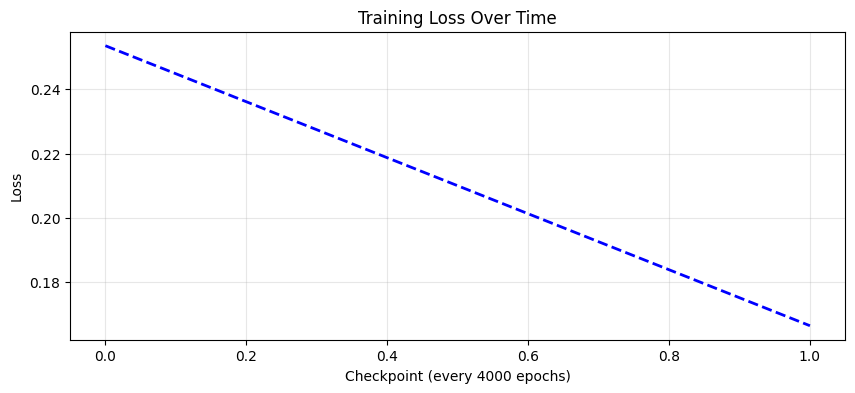


Basic model evaluation on test set:
Accuracy: 0.7580

Confusion Matrix:
[[1342  330]
 [ 479 1192]]


In [15]:
# === STEP 2: BASIC FORWARD/BACKWARD PROPAGATION TEST ===
print("\n" + "="*60)
print("STEP 2: BASIC NEURAL NETWORK TRAINING")
print("="*60)

# Create a basic neural network
nn_basic = NeuralNetwork(
    layer_sizes=[5, 3, 1],
    activations=['relu', 'sigmoid']
)

print("Architecture info:")
arch_info = nn_basic.get_architecture_info()
print(f"Layer sizes: {arch_info['layer_sizes']}")
print(f"Activations: {arch_info['activations']}")
print(f"Total parameters: {arch_info['total_parameters']}")

# Train the basic model
print("\nTraining basic model...")
nn_basic.train(X_train_scaled, y_train, epochs=8000, learning_rate=0.01)

# Plot training metrics
nn_basic.plot_training_metrices()

# Evaluate basic model
print("\nBasic model evaluation on test set:")
basic_accuracy = nn_basic.evaluate(X_test_scaled, y_test)


STEP 3: LEARNING CURVES ANALYSIS
Generating learning curves...
Training size: 1336/13369 (9.99%)
  Train Acc: 0.7552 ± 0.0040
  Val Acc: 0.7630 ± 0.0086
Training size: 2673/13369 (19.99%)
  Train Acc: 0.7548 ± 0.0038
  Val Acc: 0.7567 ± 0.0083
Training size: 4010/13369 (29.99%)
  Train Acc: 0.7621 ± 0.0052
  Val Acc: 0.7628 ± 0.0078
Training size: 5347/13369 (40.00%)
  Train Acc: 0.7607 ± 0.0015
  Val Acc: 0.7613 ± 0.0083
Training size: 6684/13369 (50.00%)
  Train Acc: 0.7610 ± 0.0026
  Val Acc: 0.7604 ± 0.0069
Training size: 8021/13369 (60.00%)
  Train Acc: 0.7650 ± 0.0028
  Val Acc: 0.7609 ± 0.0049
Training size: 9358/13369 (70.00%)
  Train Acc: 0.7636 ± 0.0029
  Val Acc: 0.7592 ± 0.0072
Training size: 10695/13369 (80.00%)
  Train Acc: 0.7609 ± 0.0036
  Val Acc: 0.7613 ± 0.0064
Training size: 12032/13369 (90.00%)
  Train Acc: 0.7608 ± 0.0006
  Val Acc: 0.7615 ± 0.0088
Training size: 13369/13369 (100.00%)
  Train Acc: 0.7609 ± 0.0027
  Val Acc: 0.7595 ± 0.0068


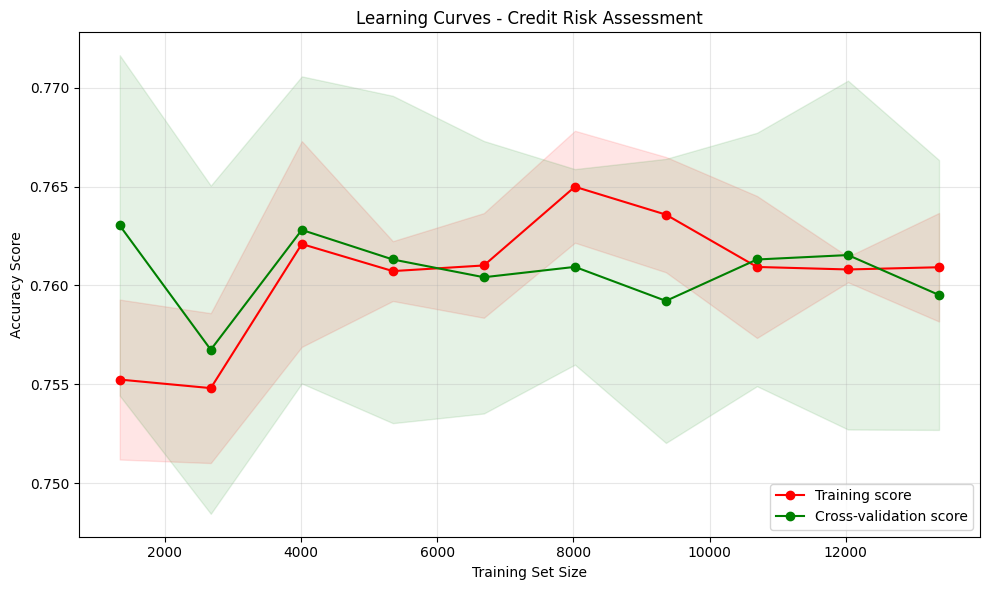


LEARNING CURVE ANALYSIS:
Final training accuracy: 0.7609
Final validation accuracy: 0.7595
Training-validation gap: 0.0014
⚠️  HIGH BIAS: Low validation accuracy suggests underfitting


In [16]:
# === STEP 3: LEARNING CURVES ANALYSIS ===
print("\n" + "="*60)
print("STEP 3: LEARNING CURVES ANALYSIS")
print("="*60)

# Create new instance for learning curves
nn_learning = NeuralNetwork(
    layer_sizes=[5, 3, 1],
    activations=['relu', 'sigmoid']
)

# Generate learning curves
learning_results = nn_learning.plot_learning_curves(
    X_train_scaled, y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv_folds=5,
    epochs=5000,
    learning_rate=0.01
)


STEP 4: ARCHITECTURE COMPARISON WITH CROSS-VALIDATION
Testing different architectures...

Testing Relu_8: [5, 8, 1] with ['relu', 'sigmoid']
Mean CV Accuracy: 0.7651 ± 0.0048

Testing Tanh_8: [5, 8, 1] with ['tanh', 'sigmoid']
Mean CV Accuracy: 0.7634 ± 0.0058

Testing Medium: [5, 8, 5, 1] with ['tanh', 'tanh', 'sigmoid']
Mean CV Accuracy: 0.7647 ± 0.0063

Testing R_T_Mix: [5, 4, 3, 2, 1] with ['relu', 'tanh', 'tanh', 'sigmoid']
Mean CV Accuracy: 0.6240 ± 0.1066

Testing Deep_mix: [5, 12, 8, 5, 1] with ['relu', 'tanh', 'relu', 'sigmoid']
Mean CV Accuracy: 0.7562 ± 0.0104

Testing Tanh_Deep: [5, 8, 5, 4, 3, 1] with ['tanh', 'tanh', 'tanh', 'tanh', 'sigmoid']
Mean CV Accuracy: 0.5996 ± 0.1724


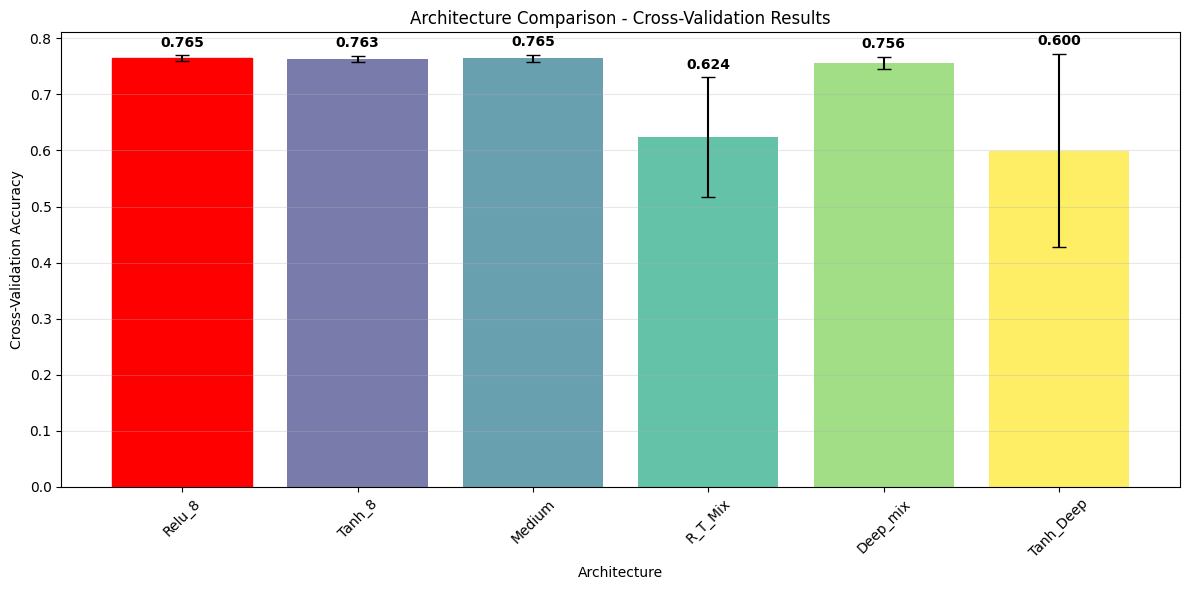

In [17]:
# === STEP 4: CROSS-VALIDATION FOR DIFFERENT ARCHITECTURES ===
print("\n" + "="*60)
print("STEP 4: ARCHITECTURE COMPARISON WITH CROSS-VALIDATION")
print("="*60)

# Define different architectures to test
architectures = [
    {'name': 'Relu_8', 'layer_sizes': [5, 8, 1], 'activations': ['relu', 'sigmoid']},
    {'name': 'Tanh_8', 'layer_sizes': [5, 8, 1], 'activations': ['tanh', 'sigmoid']},
    {'name': 'Medium', 'layer_sizes': [5, 8, 5, 1], 'activations': ['tanh', 'tanh', 'sigmoid']},
    {'name': 'R_T_Mix', 'layer_sizes': [5, 4, 3, 2, 1], 'activations': ['relu','tanh','tanh', 'sigmoid']},
    {'name': 'Deep_mix', 'layer_sizes': [5, 12, 8, 5, 1], 'activations': ['relu', 'tanh','relu', 'sigmoid']},
    {'name': 'Tanh_Deep', 'layer_sizes': [5, 8, 5, 4 ,3, 1], 'activations': ['tanh', 'tanh', 'tanh','tanh', 'sigmoid']},

]

architecture_results = {}

print("Testing different architectures...")
for arch in architectures:
    print(f"\nTesting {arch['name']}: {arch['layer_sizes']} with {arch['activations']}")

    nn_arch = NeuralNetwork(
        layer_sizes=arch['layer_sizes'],
        activations=arch['activations']
    )

    cv_results = nn_arch.train_with_cross_validation(
        X_train_scaled, y_train,
        epochs=8000,
        learning_rate=0.01,
        cv_folds=5,
        verbose=False
    )

    architecture_results[arch['name']] = cv_results
    print(f"Mean CV Accuracy: {cv_results['mean_val_accuracy']:.4f} ± {cv_results['std_val_accuracy']:.4f}")

# Plot architecture comparison
arch_names = list(architecture_results.keys())
arch_means = [architecture_results[name]['mean_val_accuracy'] for name in arch_names]
arch_stds = [architecture_results[name]['std_val_accuracy'] for name in arch_names]

plt.figure(figsize=(12, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(arch_names)))
bars = plt.bar(arch_names, arch_means, yerr=arch_stds, capsize=5, color=colors, alpha=0.7)

# Highlight best architecture
best_idx = arch_means.index(max(arch_means))
bars[best_idx].set_color('red')
bars[best_idx].set_alpha(1.0)

plt.xlabel('Architecture')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Architecture Comparison - Cross-Validation Results')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, mean, std in zip(bars, arch_means, arch_stds):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.01,
             f'{mean:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()



STEP 5: HYPERPARAMETER TUNING
Best architecture: Relu_8
Architecture: [5, 8, 1] with ['relu', 'sigmoid']

Tuning learning rate...
Generating validation curves for learning_rate...
Testing learning_rate = 0.001
Testing learning_rate = 0.005
Testing learning_rate = 0.01
Testing learning_rate = 0.05
Testing learning_rate = 0.1


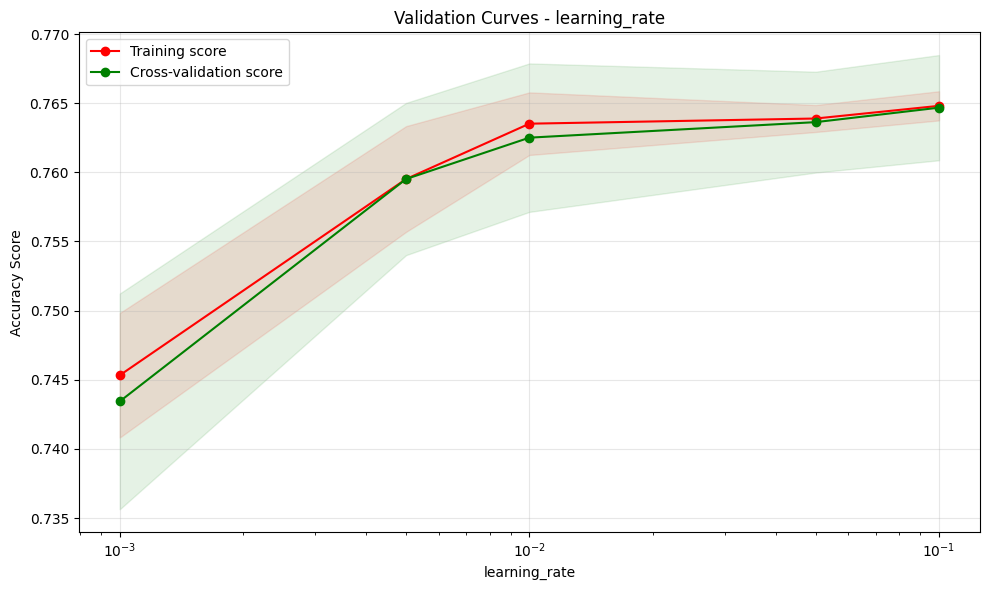


Optimal learning_rate: 0.1
Best CV score: 0.7647
Best learning rate: 0.1


In [18]:
# === STEP 5: HYPERPARAMETER TUNING ===
print("\n" + "="*60)
print("STEP 5: HYPERPARAMETER TUNING")
print("="*60)

# Find best architecture
best_arch_name = max(architecture_results.keys(),
                    key=lambda k: architecture_results[k]['mean_val_accuracy'])
best_arch = next(arch for arch in architectures if arch['name'] == best_arch_name)

print(f"Best architecture: {best_arch_name}")
print(f"Architecture: {best_arch['layer_sizes']} with {best_arch['activations']}")

# Create model with best architecture for hyperparameter tuning
nn_tuning = NeuralNetwork(
    layer_sizes=best_arch['layer_sizes'],
    activations=best_arch['activations']
)

# Tune learning rate
print("\nTuning learning rate...")
lr_range = [0.001, 0.005, 0.01, 0.05, 0.1]
lr_results = nn_tuning.validation_curves(
    X_train_scaled, y_train,
    'learning_rate', lr_range,
    cv_folds=5, epochs=4000
)

best_lr = lr_results['best_param']
print(f"Best learning rate: {best_lr}")



STEP 6: FINAL MODEL TRAINING AND EVALUATION
Training final model with best configuration...
Architecture: [5, 8, 1]
Activations: ['relu', 'sigmoid']
Learning rate: 0.1
Training with 10696 samples, validating with 2673 samples
Epoch 0 - Train Loss: 0.2472, Val Loss: 0.2470
Epoch 0 - Train Acc: 0.6674, Val Acc: 0.6652
Epoch 1000 - Train Loss: 0.1608, Val Loss: 0.1609
Epoch 1000 - Train Acc: 0.7627, Val Acc: 0.7681
Epoch 2000 - Train Loss: 0.1603, Val Loss: 0.1602
Epoch 2000 - Train Acc: 0.7631, Val Acc: 0.7681
Epoch 3000 - Train Loss: 0.1601, Val Loss: 0.1598
Epoch 3000 - Train Acc: 0.7635, Val Acc: 0.7681
Epoch 4000 - Train Loss: 0.1600, Val Loss: 0.1596
Epoch 4000 - Train Acc: 0.7639, Val Acc: 0.7669
Epoch 5000 - Train Loss: 0.1598, Val Loss: 0.1595
Epoch 5000 - Train Acc: 0.7643, Val Acc: 0.7654
Epoch 6000 - Train Loss: 0.1597, Val Loss: 0.1593
Epoch 6000 - Train Acc: 0.7643, Val Acc: 0.7654
Epoch 7000 - Train Loss: 0.1596, Val Loss: 0.1593
Epoch 7000 - Train Acc: 0.7647, Val Acc: 0.

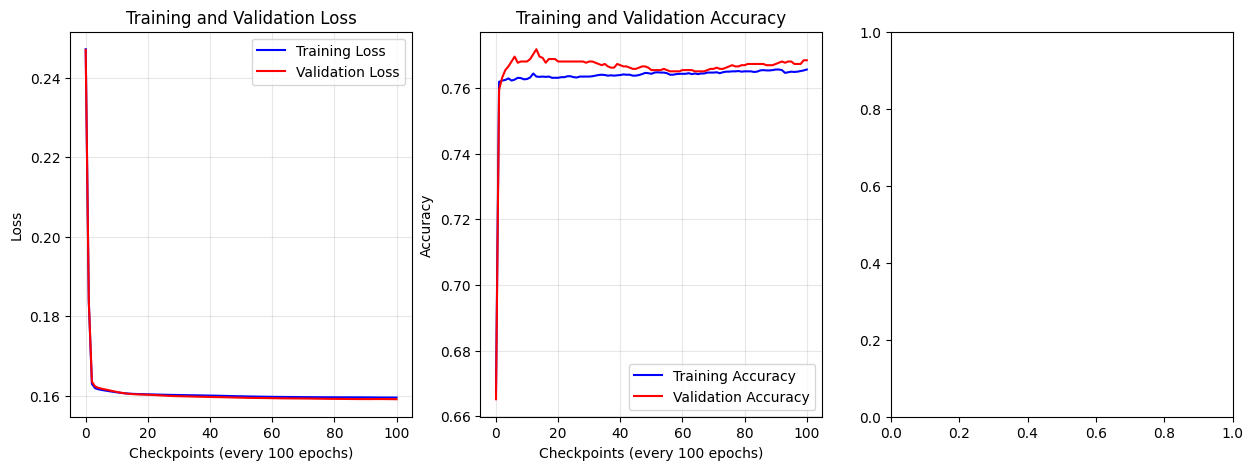

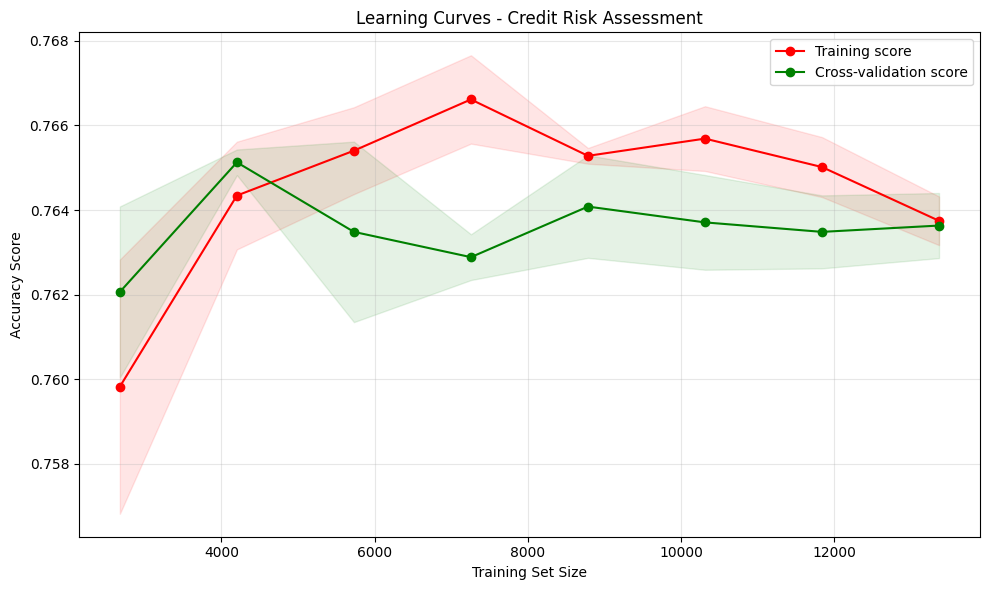


LEARNING CURVE ANALYSIS:
Final training accuracy: 0.7637
Final validation accuracy: 0.7636
Training-validation gap: 0.0001
⚠️  HIGH BIAS: Low validation accuracy suggests underfitting


<Figure size 640x480 with 0 Axes>

In [19]:
# === STEP 6: FINAL MODEL TRAINING AND COMPREHENSIVE EVALUATION ===
print("\n" + "="*60)
print("STEP 6: FINAL MODEL TRAINING AND EVALUATION")
print("="*60)

# Train final model with best configuration
final_nn = NeuralNetwork(
    layer_sizes=best_arch['layer_sizes'],
    activations=best_arch['activations']
)

print("Training final model with best configuration...")
print(f"Architecture: {best_arch['layer_sizes']}")
print(f"Activations: {best_arch['activations']}")
print(f"Learning rate: {best_lr}")

# Train with validation split to track progress
training_history = final_nn.train_with_holdout_validation(
    X_train_scaled, y_train,
    epochs=10000,
    learning_rate=best_lr,
    validation_split=0.2,
    early_stopping=True,
    patience=20,
    verbose=True
)

# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(training_history['train_losses'], label='Training Loss', color='blue')
plt.plot(training_history['val_losses'], label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Checkpoints (every 100 epochs)')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(training_history['train_accuracies'], label='Training Accuracy', color='blue')
plt.plot(training_history['val_accuracies'], label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Checkpoints (every 100 epochs)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Learning curve for final model
plt.subplot(1, 3, 3)
final_learning = final_nn.plot_learning_curves(
    X_train_scaled, y_train,
    train_sizes=np.linspace(0.2, 1.0, 8),
    cv_folds=3,
    epochs=3000,
    learning_rate=best_lr
)

plt.tight_layout()
plt.show()


In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, roc_curve
# === STEP 7: DETAILED TEST SET EVALUATION ===
print("\n" + "="*60)
print("STEP 7: COMPREHENSIVE TEST SET EVALUATION")
print("="*60)

# Predictions on test set
y_pred_proba = final_nn.feedforward(X_test_scaled)
y_pred = final_nn.predict(X_test_scaled)

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"AUC Score: {auc_score:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Good Credit', 'Bad Credit']))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Calculate precision, recall, F1 for each class
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average=None)
print(f"\nDetailed Metrics by Class:")
print(f"Class 0 (Good Credit) - Precision: {precision[0]:.4f}, Recall: {recall[0]:.4f}, F1: {f1[0]:.4f}")
print(f"Class 1 (Bad Credit)  - Precision: {precision[1]:.4f}, Recall: {recall[1]:.4f}, F1: {f1[1]:.4f}")

# Weighted average
precision_avg, recall_avg, f1_avg, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
print(f"\nWeighted Average - Precision: {precision_avg:.4f}, Recall: {recall_avg:.4f}, F1: {f1_avg:.4f}")



STEP 7: COMPREHENSIVE TEST SET EVALUATION
Test Accuracy: 0.7586
AUC Score: 0.8458

Classification Report:
              precision    recall  f1-score   support

 Good Credit       0.75      0.78      0.76      1672
  Bad Credit       0.77      0.74      0.75      1671

    accuracy                           0.76      3343
   macro avg       0.76      0.76      0.76      3343
weighted avg       0.76      0.76      0.76      3343


Confusion Matrix:
[[1300  372]
 [ 435 1236]]

Detailed Metrics by Class:
Class 0 (Good Credit) - Precision: 0.7493, Recall: 0.7775, F1: 0.7631
Class 1 (Bad Credit)  - Precision: 0.7687, Recall: 0.7397, F1: 0.7539

Weighted Average - Precision: 0.7590, Recall: 0.7586, F1: 0.7585



STEP 8: FINAL PERFORMANCE VISUALIZATION


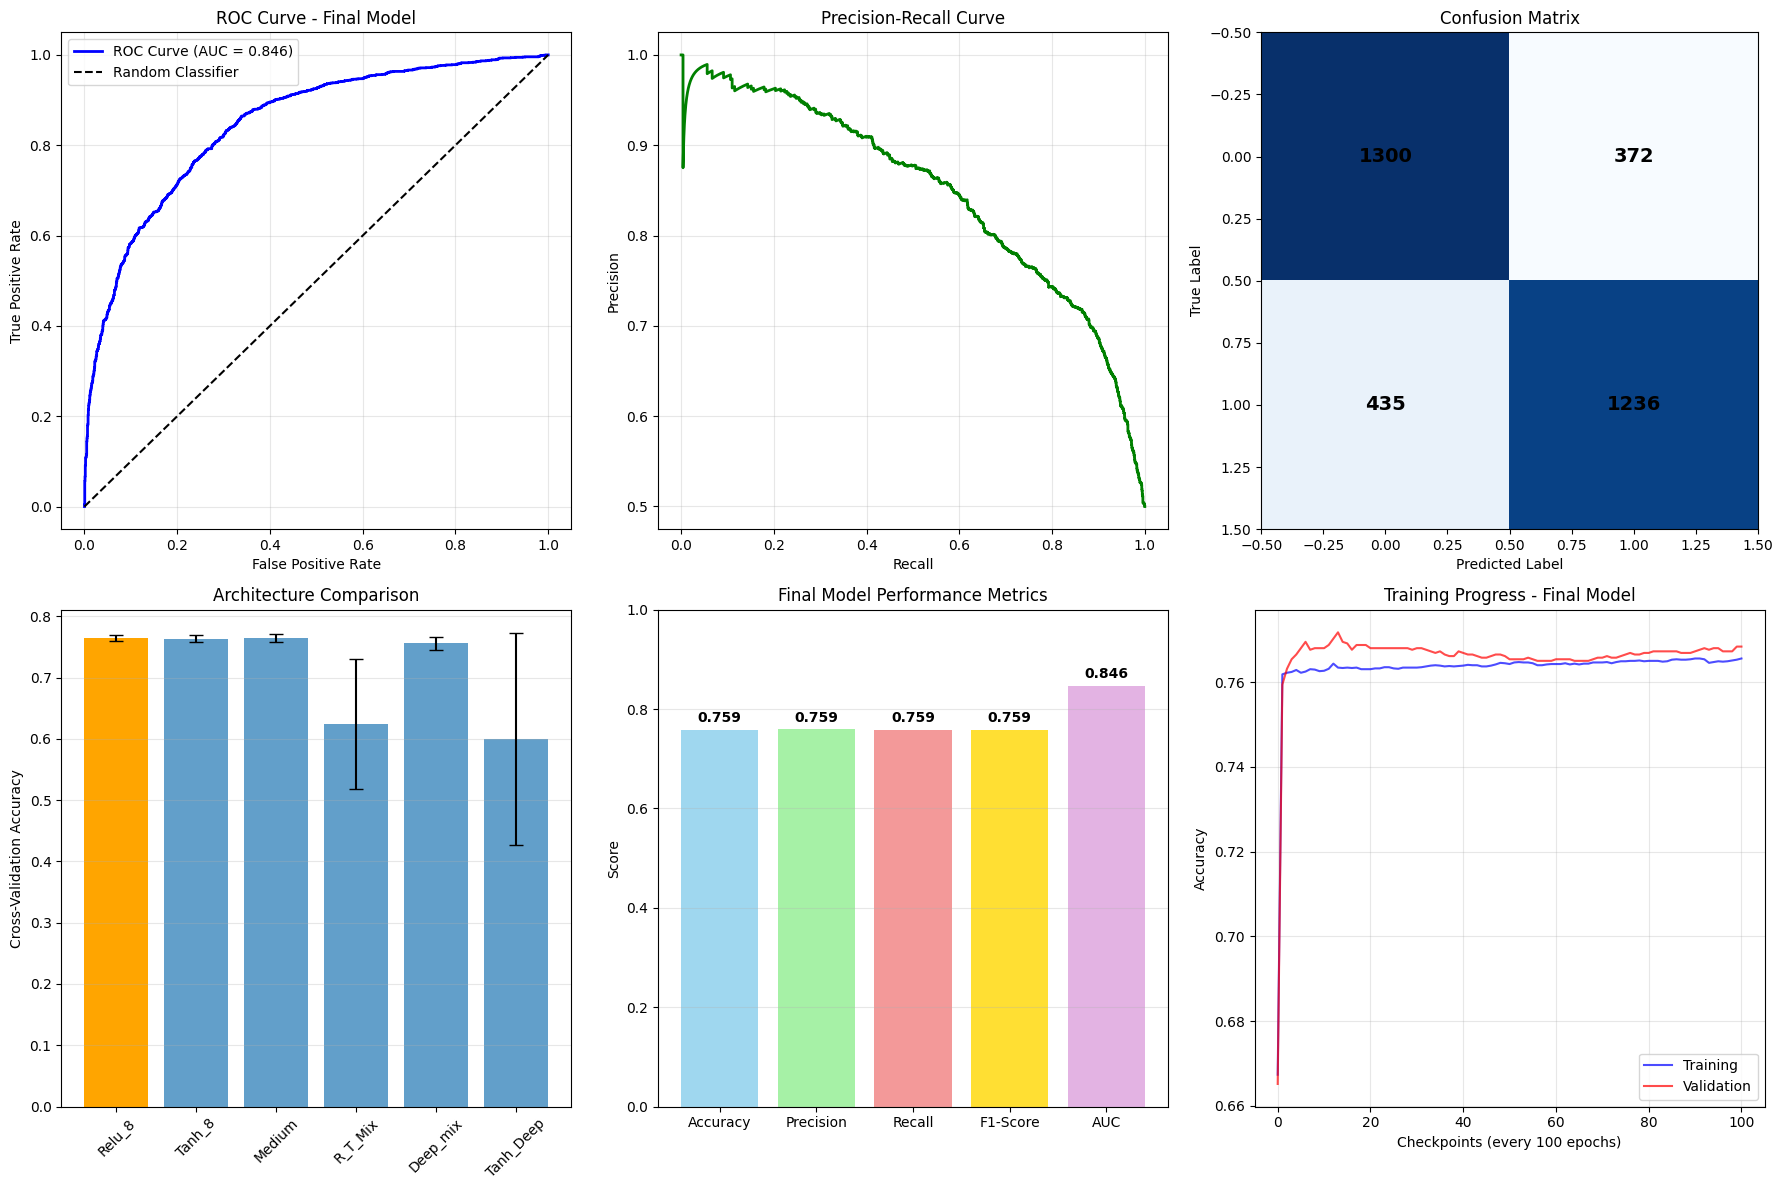


FINAL SUMMARY REPORT
Best Architecture: Relu_8
Best Architecture Details: [5, 8, 1] with ['relu', 'sigmoid']
Best Learning Rate: 0.1
Final Test Accuracy: 0.7586
AUC Score: 0.8458
Precision (weighted): 0.7590
Recall (weighted): 0.7586
F1-Score (weighted): 0.7585
Training stopped early: False
Epochs trained: 10000

Execution completed successfully! 🎉


In [21]:
# === STEP 8: FINAL VISUALIZATION ===
print("\n" + "="*60)
print("STEP 8: FINAL PERFORMANCE VISUALIZATION")
print("="*60)

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[0, 0].plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.3f})', color='blue', linewidth=2)
axes[0, 0].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].set_title('ROC Curve - Final Model')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Precision-Recall Curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
axes[0, 1].plot(recall_curve, precision_curve, color='green', linewidth=2)
axes[0, 1].set_xlabel('Recall')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_title('Precision-Recall Curve')
axes[0, 1].grid(True, alpha=0.3)

# Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)
im = axes[0, 2].imshow(cm, interpolation='nearest', cmap='Blues')
axes[0, 2].set_title('Confusion Matrix')
axes[0, 2].set_ylabel('True Label')
axes[0, 2].set_xlabel('Predicted Label')
# Add text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        axes[0, 2].text(j, i, str(cm[i, j]), ha='center', va='center', fontsize=14, fontweight='bold')

# Architecture comparison (from earlier)
axes[1, 0].bar(arch_names, arch_means, yerr=arch_stds, capsize=5, alpha=0.7)
best_idx = arch_means.index(max(arch_means))
axes[1, 0].bar(arch_names[best_idx], arch_means[best_idx], color='orange', alpha=1.0)
axes[1, 0].set_ylabel('Cross-Validation Accuracy')
axes[1, 0].set_title('Architecture Comparison')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

# Metrics comparison
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [test_accuracy, precision_avg, recall_avg, f1_avg, auc_score]
colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold', 'plum']
bars = axes[1, 1].bar(metrics_names, metrics_values, color=colors, alpha=0.8)
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Final Model Performance Metrics')
axes[1, 1].set_ylim([0, 1])
axes[1, 1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, metrics_values):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# Training progress
axes[1, 2].plot(training_history['train_accuracies'], label='Training', color='blue', alpha=0.7)
axes[1, 2].plot(training_history['val_accuracies'], label='Validation', color='red', alpha=0.7)
axes[1, 2].set_xlabel('Checkpoints (every 100 epochs)')
axes[1, 2].set_ylabel('Accuracy')
axes[1, 2].set_title('Training Progress - Final Model')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# === SUMMARY REPORT ===
print("\n" + "="*80)
print("FINAL SUMMARY REPORT")
print("="*80)
print(f"Best Architecture: {best_arch_name}")
print(f"Best Architecture Details: {best_arch['layer_sizes']} with {best_arch['activations']}")
print(f"Best Learning Rate: {best_lr}")
print(f"Final Test Accuracy: {test_accuracy:.4f}")
print(f"AUC Score: {auc_score:.4f}")
print(f"Precision (weighted): {precision_avg:.4f}")
print(f"Recall (weighted): {recall_avg:.4f}")
print(f"F1-Score (weighted): {f1_avg:.4f}")
print(f"Training stopped early: {training_history['stopped_early']}")
print(f"Epochs trained: {training_history['epochs_trained']}")
print("="*80)

print("\nExecution completed successfully! 🎉")